### Importing necessary libraries

In [1]:
from sklearn.preprocessing import MinMaxScaler

import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
### Defining necessary constants

DATA_FOLDER = '/home/faranio/Desktop/EDISS/Courses/1st Year. Period 1/Data Intensive Engineering ' \
              'I/Brain-Neuroactivity/data/'

VIDEOS_FOLDER = os.path.join(DATA_FOLDER, '02_converted')
TABLES_FOLDER = os.path.join(DATA_FOLDER, '07_pose_tables')
BORDERS_FOLDER = os.path.join(DATA_FOLDER, '10_borders_tables')

MAIN_FEATURES = [
    'Lower_Body_To_Body_Distance_12',
    'Mean_Body_Position_Distance_12',
    'Nose_To_Nose_Distance_12',
    'Nose_To_Body_Distance_12',
    'Nose_To_Back_Distance_12',
    'Nose_To_Tail_End_Distance_12'
]

ARENA_LENGTH = 45 # in cm
PROXIMITY = 7     # in cm

### Reading Pose and Borders keypoints

In [3]:
VIDEO_FILE_NAME = 'Trial_1_v1_SI_w2_control_2593.mp4'

cap = cv2.VideoCapture(os.path.join(VIDEOS_FOLDER, VIDEO_FILE_NAME))
FPS = cap.get(cv2.CAP_PROP_FPS)
FRAME_COUNT = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
DURATION = FRAME_COUNT/FPS # in seconds
BIN_LENGTH = 60            # in seconds
INTERVAL = int(BIN_LENGTH * FPS)

pose_keypoints_path = os.path.join(TABLES_FOLDER, f'{VIDEO_FILE_NAME}.predictions.h5')
borders_keypoints_path = os.path.join(BORDERS_FOLDER, f'{VIDEO_FILE_NAME}.predictions.h5')

pose_tables = h5py.File(pose_keypoints_path, 'r')
border_tables = h5py.File(borders_keypoints_path, 'r')

**Main keys:**

- Instance scores
- Node names
- Point scores
- Tracks

In [4]:
pose_scores = list(pose_tables['instance_scores'][0])
border_scores = list(border_tables['instance_scores'][0])

len(pose_scores), len(border_scores)

(7571, 7571)

In [5]:
pose_node_names = [str(x)[2:-1] for x in pose_tables['node_names'][:]]
border_node_names = [str(x)[2:-1] for x in border_tables['node_names'][:]]

print('Pose Node names:\n')

for node in pose_node_names:
    print(f'- {node}')

print('\nBorder Node names:\n')

for node in border_node_names:
    print(f'- {node}')

Pose Node names:

- Nose_1
- Upper_Body_1
- Lower_Body_1
- Back_1
- Tail_Middle_1
- Tail_End_1
- Left_Hand_1
- Right_Hand_1
- Left_Leg_1
- Right_Leg_1
- Nose_2
- Body_2
- Back_2
- Tail_Middle_2
- Tail_End_2

Border Node names:

- Left_Upper_Corner
- Right_Upper_Corner
- Right_Lower_Corner
- Left_Lower_Corner


In [6]:
pose_point_scores = pose_tables['point_scores'][0].transpose()
border_point_scores = border_tables['point_scores'][0].transpose()

pose_point_scores.shape, border_point_scores.shape

((7571, 15), (7571, 4))

In [7]:
pose_x, pose_y = pose_tables['tracks'][0]
border_x, border_y = border_tables['tracks'][0]

pose_x, pose_y = pose_x.transpose(), pose_y.transpose()
border_x, border_y = border_x.transpose(), border_y.transpose()

pose_x.shape, pose_y.shape, border_x.shape, border_y.shape

((7571, 15), (7571, 15), (7571, 4), (7571, 4))

### Reading video file

In [9]:
cap = cv2.VideoCapture(os.path.join(VIDEOS_FOLDER, VIDEO_FILE_NAME))
idx = 0

while cap.isOpened():      
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    for i in range(pose_x.shape[1]):
        try:
            gray = cv2.circle(gray, (int(pose_x[idx][i]), int(pose_y[idx][i])), 3, (255, 0, 255), 3)
        except ValueError:
            continue
            
    for i in range(border_x.shape[1]):
        try:
            gray = cv2.circle(gray, (int(border_x[idx][i]), int(border_y[idx][i])), 3, (255, 0, 255), 3)
        except ValueError:
            continue
            
    for i in range(5):
        try:
            gray = cv2.line(gray, (int(pose_x[idx][i]), int(pose_y[idx][i])), (int(pose_x[idx][i+1]), int(pose_y[idx][i+1])), (255, 0, 255), 3)
        except ValueError:
            continue
            
    for i, j in zip([1, 1, 2, 2], [6, 7, 8, 9]):
        try:
            gray = cv2.line(gray, (int(pose_x[idx][i]), int(pose_y[idx][i])), (int(pose_x[idx][j]), int(pose_y[idx][j])), (255, 0, 255), 3)
        except ValueError:
            continue
                
    for i in range(10, 14):
        try:
            gray = cv2.line(gray, (int(pose_x[idx][i]), int(pose_y[idx][i])), (int(pose_x[idx][i+1]), int(pose_y[idx][i+1])), (255, 0, 255), 3)
        except ValueError:
            continue
            
#     gray = cv2.putText(gray, str(normalized_df.loc[idx, 'Nose_To_Nose_Is_Close']), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)
    
    cv2.imshow('frame',gray)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
    idx += 1

cap.release()
cv2.destroyAllWindows()

### Exploratory Data Analysis

In [29]:
# Calculating Mean Corner Coordinates

border_x_mean, border_y_mean = np.nanmean(border_x, axis=0), np.nanmean(border_y, axis=0)

left_upper_corner = (border_x_mean[0], border_y_mean[0])
right_upper_corner = (border_x_mean[1], border_y_mean[1])
right_lower_corner = (border_x_mean[2], border_y_mean[2])
left_lower_corner = (border_x_mean[3], border_y_mean[3])

UNITS_PER_CM = np.linalg.norm(np.array(right_upper_corner) - np.array(left_upper_corner)) / ARENA_LENGTH

In [30]:
# Getting Pose Keypoints

columns = []

for node_name in pose_node_names:
    columns.append(f'{node_name}_x')
    columns.append(f'{node_name}_y')

df = pd.DataFrame(pose_x, columns=[i + '_x' for i in pose_node_names]).join(
    pd.DataFrame(pose_y, columns=[i + '_y' for i in pose_node_names])
)

df = df[columns]

In [31]:
# Calculating Mean Body Positions of mice

df['Mean_Body_Position_1_x'] = df[['Nose_1_x', 'Upper_Body_1_x', 'Lower_Body_1_x', 'Back_1_x']].mean(axis=1)
df['Mean_Body_Position_1_y'] = df[['Nose_1_y', 'Upper_Body_1_y', 'Lower_Body_1_y', 'Back_1_y']].mean(axis=1)

df['Mean_Body_Position_2_x'] = df[['Nose_2_x', 'Body_2_x', 'Back_2_x']].mean(axis=1)
df['Mean_Body_Position_2_y'] = df[['Nose_2_y', 'Body_2_y', 'Back_2_y']].mean(axis=1)

df['Mean_Body_Position_Distance_12'] = np.linalg.norm(df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']].values - df[['Mean_Body_Position_2_x', 'Mean_Body_Position_2_y']].values, axis=1)

df['Close_Proximity'] = (df['Mean_Body_Position_Distance_12'] / UNITS_PER_CM) <= PROXIMITY
df['Close_Proximity'] = df['Close_Proximity'].astype(int)

In [35]:
# Calculating the total distance moved by the subject

def total_distance(pos1, pos2):
    distances = np.linalg.norm(pos2.values - pos1.values, axis=1)
    distances = distances[~np.isnan(distances)]
    distance_in_cm = sum(distances) / UNITS_PER_CM
    return distance_in_cm

def total_time_of_interaction(col):
    total_time = DURATION * col.sum() / FRAME_COUNT
    return total_time

def frequency_of_interaction(interaction_time, length):
    frequency = interaction_time / length
    return frequency

def latency_to_first_interaction(col):
    frames = 0

    for idx, val in col.items():
        if val == 0:
            frames += 1
        else:
            break
            
    if frames == len(col):
        return -1

    latency = frames / FRAME_COUNT * DURATION
    
    return latency

def time_stamped_interaction(col):
    time_series = []
    
    for k, v in col.items():
        if v != 0:
            val = v * k / FRAME_COUNT * DURATION
            val = round(val, 2)
            time_series.append(val)
        
    return time_series

In [41]:
def print_features(df, show_small_bin=True):
    for i in range(0, len(df), INTERVAL):
        temp_df = df[i:i+INTERVAL]
        
        if len(temp_df) < INTERVAL and not show_small_bin:
            continue

        time_of_interaction = total_time_of_interaction(temp_df['Close_Proximity'])
        first_interaction_latency = latency_to_first_interaction(temp_df['Close_Proximity'])
        time_stamped_active_interaction = time_stamped_interaction(temp_df['Close_Proximity'])
        interaction_frequency = frequency_of_interaction(time_of_interaction, BIN_LENGTH)

        distance_traveled = total_distance(
            temp_df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']], 
            temp_df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']].shift()
        )

        print("Frequency of interaction (interaction/second): %4.2f" % interaction_frequency)
        print("Latency to first interaction              (s): %4.2f" % first_interaction_latency)
        print("Total time of active interaction          (s): %4.2f" % time_of_interaction)
        print("Bin duration time                         (s): %4.2f" % (len(temp_df) / FRAME_COUNT * DURATION))
        print("Total distance moved by the subject      (cm): %4.2f\n" % distance_traveled)
    #     print("Time stamped active interaction              : %s\n"  % time_stamped_active_interaction)
        print('*' * 110)

    time_of_interaction = total_time_of_interaction(df['Close_Proximity'])
    first_interaction_latency = latency_to_first_interaction(df['Close_Proximity'])
    time_stamped_active_interaction = time_stamped_interaction(df['Close_Proximity'])
    interaction_frequency = frequency_of_interaction(time_of_interaction, DURATION)

    distance_traveled = total_distance(
        df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']], 
        df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']].shift()
    )

    print("TOTAL VALUES FOR THE WHOLE VIDEO:\n")
    print("Frequency of interaction (interaction/second): %4.2f" % interaction_frequency)
    print("Latency to first interaction              (s): %4.2f" % first_interaction_latency)
    print("Total time of active interaction          (s): %4.2f" % time_of_interaction)
    print("Video duration time                       (s): %4.2f" % DURATION)
    print("Total distance moved by the subject      (cm): %4.2f" % distance_traveled)
    # print("Time stamped active interaction              : %s"    % time_stamped_active_interaction)

In [43]:
print_features(df, False)

Frequency of interaction (interaction/second): 0.30
Latency to first interaction              (s): 20.44
Total time of active interaction          (s): 18.24
Bin duration time                         (s): 60.00
Total distance moved by the subject      (cm): 353.32

**************************************************************************************************************
Frequency of interaction (interaction/second): 0.23
Latency to first interaction              (s): 19.96
Total time of active interaction          (s): 13.80
Bin duration time                         (s): 60.00
Total distance moved by the subject      (cm): 366.19

**************************************************************************************************************
Frequency of interaction (interaction/second): 0.12
Latency to first interaction              (s): 10.20
Total time of active interaction          (s): 7.12
Bin duration time                         (s): 60.00
Total distance moved by the subject 

In [11]:
# Calculating the Euclidean distance between Mean Body Position and each corner

df['Left_Upper_Corner_Distance_1'] = np.linalg.norm(
    df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']].values - left_upper_corner, 
    axis=1
)
df['Right_Upper_Corner_Distance_1'] = np.linalg.norm(
    df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']].values - right_upper_corner, 
    axis=1
)
df['Right_Lower_Corner_Distance_1'] = np.linalg.norm(
    df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']].values - right_lower_corner, 
    axis=1
)
df['Left_Lower_Corner_Distance_1'] = np.linalg.norm(
    df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']].values - left_lower_corner, 
    axis=1
)

In [12]:
# Calculating Euclidean distances between Mean Body Position and each border

df['Upper_Border_Distance_1'] = np.linalg.norm(
    np.expand_dims(
        np.cross(
            np.array(right_upper_corner) - np.array(left_upper_corner), 
            left_upper_corner - df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']].values
        ), axis=1
    ), axis=1
) / np.linalg.norm(np.array(left_upper_corner) - np.array(right_upper_corner))
df['Left_Border_Distance_1'] = np.linalg.norm(
    np.expand_dims(
        np.cross(
            np.array(left_lower_corner) - np.array(left_upper_corner), 
            left_upper_corner - df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']].values
        ), axis=1
    ), axis=1
) / np.linalg.norm(np.array(left_lower_corner) - np.array(left_upper_corner))
df['Right_Border_Distance_1'] = np.linalg.norm(
    np.expand_dims(
        np.cross(
            np.array(right_upper_corner) - np.array(right_lower_corner), 
            right_lower_corner - df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']].values
        ), axis=1
    ), axis=1
) / np.linalg.norm(np.array(right_upper_corner) - np.array(right_lower_corner))
df['Lower_Border_Distance_1'] = np.linalg.norm(
    np.expand_dims(
        np.cross(
            np.array(left_lower_corner) - np.array(right_lower_corner), 
            right_lower_corner - df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']].values
        ), axis=1
    ), axis=1
) / np.linalg.norm(np.array(left_lower_corner) - np.array(right_lower_corner))

In [13]:
# Calculating Distances between Body Parts

df['Nose_To_Tail_End_Distance_1'] = np.linalg.norm(df[['Nose_1_x', 'Nose_1_y']].values - df[['Tail_End_1_x', 'Tail_End_1_y']].values, axis=1)
df['Nose_To_Left_Hand_Distance_1'] = np.linalg.norm(df[['Nose_1_x', 'Nose_1_y']].values - df[['Left_Hand_1_x', 'Left_Hand_1_y']].values, axis=1)
df['Nose_To_Right_Hand_Distance_1'] = np.linalg.norm(df[['Nose_1_x', 'Nose_1_y']].values - df[['Right_Hand_1_x', 'Right_Hand_1_y']].values, axis=1)

df['Nose_To_Nose_Distance_12'] = np.linalg.norm(df[['Nose_1_x', 'Nose_1_y']].values - df[['Nose_2_x', 'Nose_2_y']].values, axis=1)
df['Nose_To_Body_Distance_12'] = np.linalg.norm(df[['Nose_1_x', 'Nose_1_y']].values - df[['Body_2_x', 'Body_2_y']].values, axis=1)
df['Nose_To_Back_Distance_12'] = np.linalg.norm(df[['Nose_1_x', 'Nose_1_y']].values - df[['Back_2_x', 'Back_2_y']].values, axis=1)
df['Nose_To_Tail_End_Distance_12'] = np.linalg.norm(df[['Nose_1_x', 'Nose_1_y']].values - df[['Tail_End_2_x', 'Tail_End_2_y']].values, axis=1)

df['Lower_Body_To_Body_Distance_12'] = np.linalg.norm(df[['Lower_Body_1_x', 'Lower_Body_1_y']].values - df[['Body_2_x', 'Body_2_y']].values, axis=1)

df['Mean_Body_Position_Distance_12'] = np.linalg.norm(df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']].values - df[['Mean_Body_Position_2_x', 'Mean_Body_Position_2_y']].values, axis=1)

In [14]:
df

Nose_1_x    Nose_1_y  Nose_1_score  Upper_Body_1_x  Upper_Body_1_y  \
0     659.926880  315.880371      1.036040      695.987488      312.171509   
1     656.126770  315.832092      1.009236      695.921631      312.069763   
2     656.125916  315.832703      1.009185      695.921082      312.069794   
3     655.862915  312.018158      1.035435      695.875061      312.053345   
4     655.910034  316.019531      1.026120      691.968567      311.948853   
...          ...         ...           ...             ...             ...   
7567  824.075439  572.215820      1.097577      835.757935      611.994263   
7568  824.211365  572.211853      1.073658      835.862061      612.016907   
7569  824.232849  572.235046      1.053166      835.899353      612.021973   
7570  828.059875  572.325500      1.059763      835.960266      612.085388   
7571  831.933838  575.930420      1.083569      836.005005      612.067505   

      Upper_Body_1_score  Lower_Body_1_x  Lower_Body_1_y  Lower_Body_1_score  \
0               1.063026      751.886719      316.088593            0.951200   
1               1.044179      744.045288      312.199951            0.925706   
2               1.044172      744.045227      312.199860            0.925613   
3               1.036032      743.880249      312.144379            0.947990   
4               1.046119      739.987244      308.118866            0.979667   
...                  ...             ...             ...                 ...   
7567            1.025276      859.780701      644.164551            0.979444   
7568            1.023515      859.785706      647.989075            0.979587   
7569            1.025819      856.032227      648.046448            0.985892   
7570            1.025717      856.074951      648.072998            0.984810   
7571            1.015209      859.843140      648.051392            0.971007   

        Back_1_x  ...  Lower_Border_Distance_1  Nose_To_Tail_End_Distance_1  \
0     775.747498  ...               609.694114                   178.320031   
1     768.089111  ...               609.731834                   192.188655   
2     768.089050  ...               609.731654                   192.191029   
3     764.211060  ...               611.666459                   197.091424   
4     763.934509  ...               612.682805                   192.366935   
...          ...  ...                      ...                          ...   
7567  867.919067  ...               303.042347                   172.478302   
7568  867.899536  ...               302.043816                   176.170250   
7569  867.945374  ...               302.011015                   179.218341   
7570  867.959473  ...               301.981441                   175.495186   
7571  868.043335  ...               300.162947                   171.934044   

      Nose_To_Left_Hand_Distance_1  Nose_To_Right_Hand_Distance_1  \
0                              NaN                            NaN   
1                              NaN                            NaN   
2                              NaN                            NaN   
3                              NaN                            NaN   
4                              NaN                            NaN   
...                            ...                            ...   
7567                           NaN                            NaN   
7568                           NaN                            NaN   
7569                           NaN                            NaN   
7570                           NaN                            NaN   
7571                           NaN                            NaN   

      Nose_To_Nose_Distance_12  Nose_To_Body_Distance_12  \
0                   467.829038                425.244334   
1                   460.504382                429.513339   
2                   460.503422                429.512274   
3                   465.274117                433.784064   
4                   466.943470  

In [16]:
# Normalizing time series features (for better generalization)

scaler = MinMaxScaler()

normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [51]:
DISTANCE_THRESHOLD = 0.025

for col_name in MAIN_FEATURES:
    new_col = '_'.join(col_name.split('_')[:-2]) + '_Is_Close'
    normalized_df[new_col] = normalized_df[col_name] <= DISTANCE_THRESHOLD

normalized_df

Nose_1_x  Nose_1_y  Nose_1_score  Upper_Body_1_x  Upper_Body_1_y  \
0     0.482385  0.075220      0.777525        0.552879        0.023194   
1     0.475744  0.075137      0.757409        0.552755        0.023000   
2     0.475743  0.075138      0.757371        0.552753        0.023000   
3     0.475283  0.068606      0.777071        0.552666        0.022969   
4     0.475365  0.075458      0.770080        0.545263        0.022769   
...        ...       ...           ...             ...             ...   
7567  0.769247  0.514154      0.823707        0.817776        0.595328   
7568  0.769484  0.514147      0.805756        0.817974        0.595371   
7569  0.769522  0.514187      0.790377        0.818044        0.595380   
7570  0.776210  0.514342      0.795328        0.818160        0.595501   
7571  0.782980  0.520515      0.813194        0.818245        0.595467   

      Upper_Body_1_score  Lower_Body_1_x  Lower_Body_1_y  Lower_Body_1_score  \
0               0.828565        0.648610        0.045369            0.837196   
1               0.813875        0.633649        0.038002            0.814758   
2               0.813869        0.633649        0.038002            0.814676   
3               0.807525        0.633334        0.037897            0.834371   
4               0.815387        0.625907        0.030271            0.862252   
...                  ...             ...             ...                 ...   
7567            0.799141        0.854465        0.666871            0.862055   
7568            0.797769        0.854475        0.674116            0.862181   
7569            0.799564        0.847313        0.674224            0.867730   
7570            0.799484        0.847395        0.674275            0.866778   
7571            0.791295        0.854584        0.674234            0.854630   

      Back_1_x  ...  Nose_To_Back_Distance_12  Nose_To_Tail_End_Distance_12  \
0     0.687993  ...                  0.559263                      0.445182   
1     0.674111  ...                  0.561216                      0.436945   
2     0.674111  ...                  0.561215                      0.437025   
3     0.667081  ...                  0.566697                      0.433135   
4     0.666580  ...                  0.567725                      0.433168   
...        ...  ...                       ...                           ...   
7567  0.855073  ...                  0.316167                      0.197367   
7568  0.855038  ...                  0.316061                      0.197555   
7569  0.855121  ...                  0.316127                      0.192135   
7570  0.855146  ...                  0.315615                      0.193216   
7571  0.855298  ...                  0.320212                      0.205376   

      Lower_Body_To_Body_Distance_12  Mean_Body_Position_Distance_12  \
0                           0.732659                        0.714777   
1                           0.737637                        0.711018   
2                           0.737637                        0.711017   
3                           0.738143                        0.713388   
4                           0.744267                        0.718731   
...                              ...                             ...   
7567                        0.465198                        0.449881   
7568                        0.465210                        0.449270   
7569                        0.465865                        0.449614   
7570                        0.471841                        0.453727   
7571                        0.471617                        0.456350   

      Lower_Body_To_Body_Is_Close  Mean_Body_Position_Is_Close  \
0                           False                        False   
1                           False                        False   
2                           False                        False   
3                           False                        False   
4           

<AxesSubplot:>

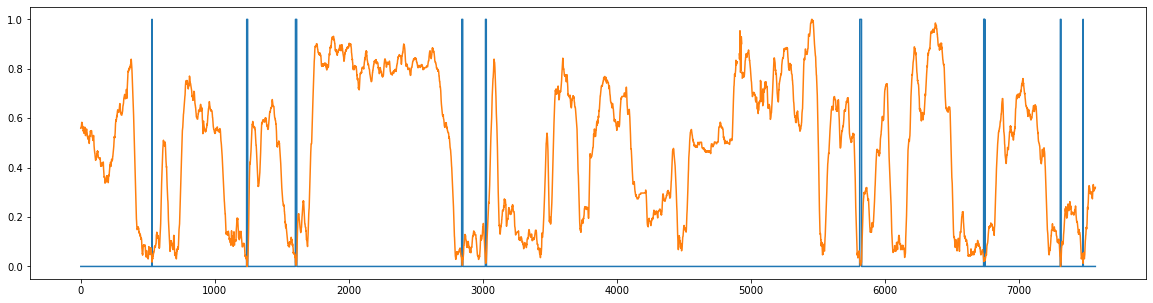

In [52]:
fig, ax = plt.subplots(figsize=(20, 5), sharex=True)
normalized_df['Nose_To_Back_Is_Close'].astype(int).plot(ax=ax)
normalized_df['Nose_To_Back_Distance_12'].plot(ax=ax)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7572 entries, 0 to 7571
Data columns (total 66 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Nose_1_x                        7551 non-null   float64
 1   Nose_1_y                        7551 non-null   float64
 2   Nose_1_score                    7572 non-null   float64
 3   Upper_Body_1_x                  7571 non-null   float64
 4   Upper_Body_1_y                  7571 non-null   float64
 5   Upper_Body_1_score              7572 non-null   float64
 6   Lower_Body_1_x                  7563 non-null   float64
 7   Lower_Body_1_y                  7563 non-null   float64
 8   Lower_Body_1_score              7572 non-null   float64
 9   Back_1_x                        7554 non-null   float64
 10  Back_1_y                        7554 non-null   float64
 11  Back_1_score                    7572 non-null   float64
 12  Tail_Middle_1_x                 75

In [19]:
df.describe()

Nose_1_x     Nose_1_y  Nose_1_score  Upper_Body_1_x  Upper_Body_1_y  \
count  7551.000000  7551.000000   7572.000000     7571.000000     7571.000000   
mean    727.298277   573.152933      0.973974      725.406089      568.736782   
std     201.927258   198.631005      0.122629      198.353700      201.394005   
min     383.895142   271.952301      0.000000      404.265930      300.016663   
25%     480.041214   375.786285      0.933067      479.711075      352.006439   
50%     852.184204   576.162415      0.992729      859.874695      580.160095   
75%     895.996918   772.073334      1.044562      891.833435      776.244415   
max     956.117798   855.947754      1.332485      931.906494      824.060242   

       Upper_Body_1_score  Lower_Body_1_x  Lower_Body_1_y  Lower_Body_1_score  \
count         7572.000000     7563.000000     7563.000000         7572.000000   
mean             0.993174      724.402016      567.192394            0.973411   
std              0.080503      197.781189      208.935253            0.073233   
min              0.000000      411.932922      292.139465            0.000000   
25%              0.967870      487.881058      340.036270            0.961128   
50%              1.002387      843.878357      588.025391            0.982275   
75%              1.033463      899.944092      788.120361            1.004235   
max              1.282973      936.059448      820.015564            1.136173   

          Back_1_x  ...  Lower_Border_Distance_1  Nose_To_Tail_End_Distance_1  \
count  7554.000000  ...              7571.000000                  7443.000000   
mean    722.206657  ...               356.090814                   143.131476   
std     198.433674  ...               203.612534                    37.606107   
min     396.207977  ...               103.180763                    17.137004   
25%     496.065865  ...               144.529610                   116.380893   
50%     827.854675  ...               340.570181                   153.792402   
75%     900.119934  ...               569.875815                   173.497046   
max     947.869812  ...               617.877570                   211.814669   

       Nose_To_Left_Hand_Distance_1  Nose_To_Right_Hand_Distance_1  \
count                    612.000000                     305.000000   
mean                      41.155974                      19.061249   
std                       37.133149                      32.619362   
min                        0.121164                       0.197220   
25%                       16.457273                       8.880884   
50%                       40.381841                      12.505957   
75%                       54.581564                      20.505456   
max                      544.604683                     540.386891   

       Nose_To_Nose_Distance_12  Nose_To_Body_Distance_12  \
count               7551.000000               7551.000000   
mean                 335.281961                329.337381   
std                  193.112716                195.250788   
min                    0.068921                 12.836794   
25%                  137.469682                125.360394   
50%                  377.348023                367.796622   
75%                  506.414377                497.137877   
max                  712.502040                668.186619   

       Nose_To_Back_Distance_12  Nose_To_Tail_End_Distance_12  \
count               7551.000000                   7499.000000   
mean                 327.864669                    330.392142   
std                  196.495957                    188.825377   
min                    0.391373                      4.122274   
25%                  124.987149                    164.705346   
50%                  355.033341                    311.345030   
75%                  493.986652                    493.173210   
max                  701.343549                    720.005932   

       Lower_Body_To_Body_Distance_12  Mean_Body_Posi

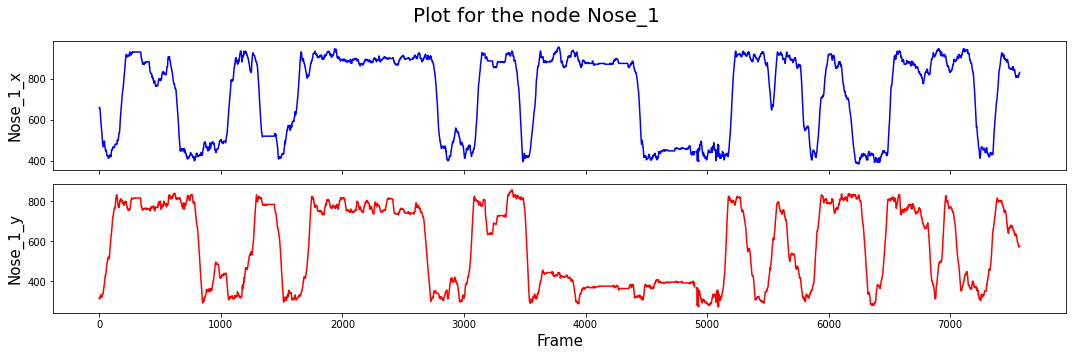

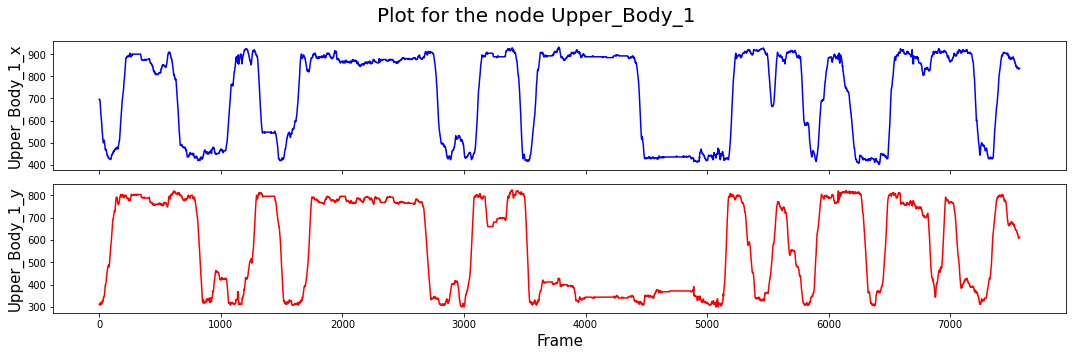

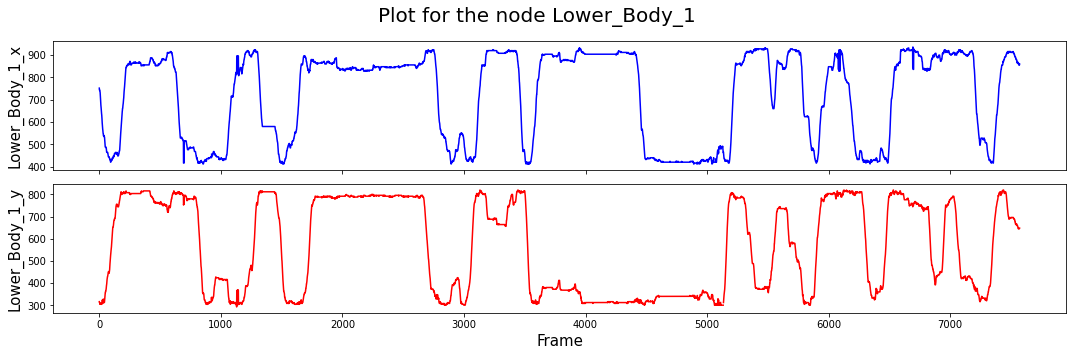

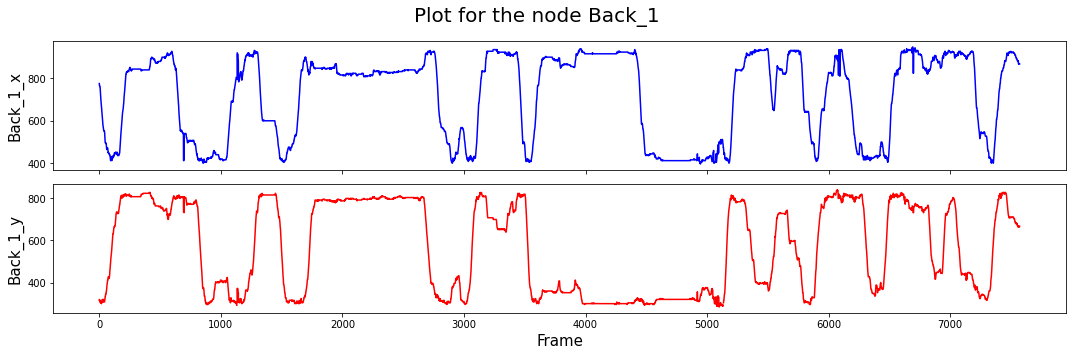

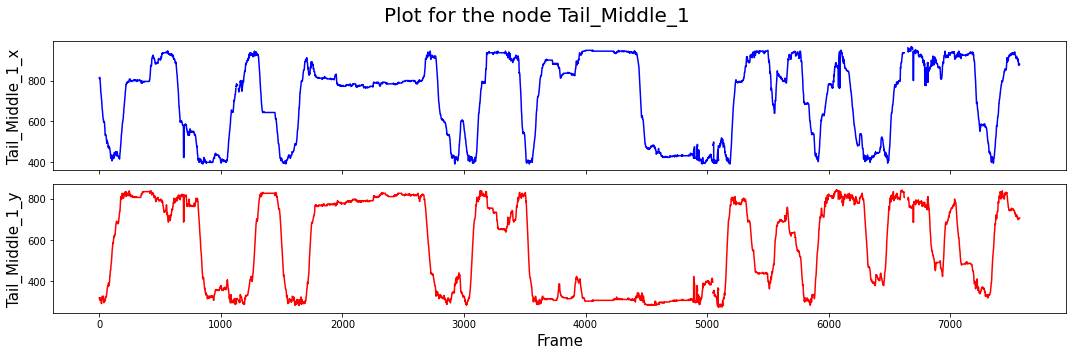

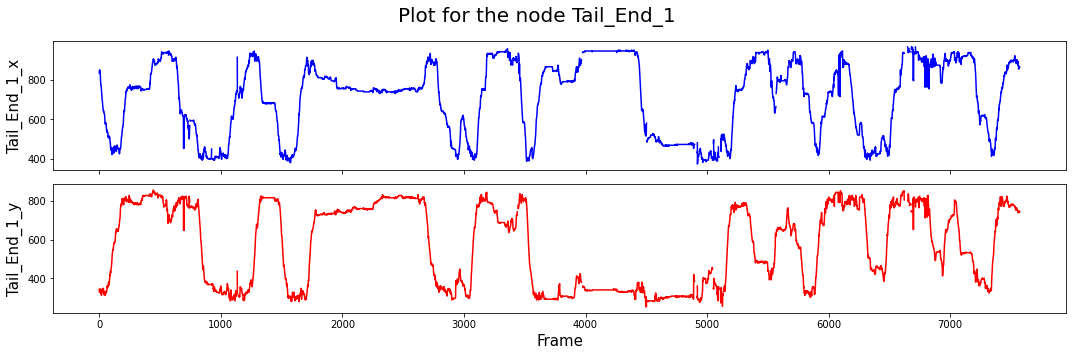

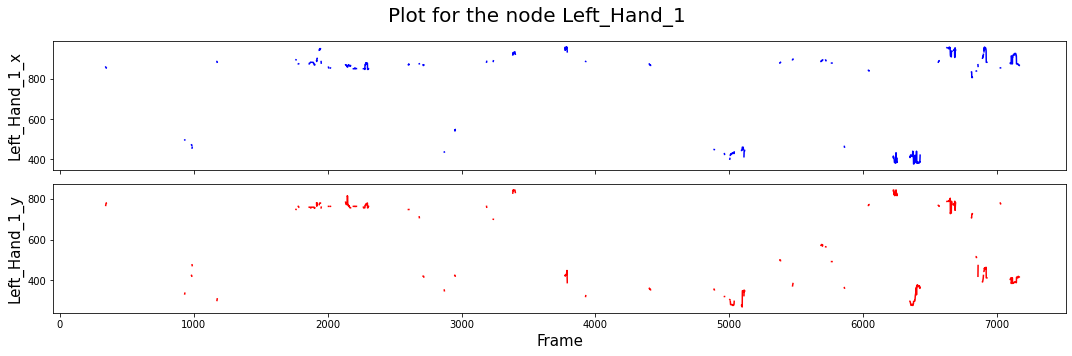

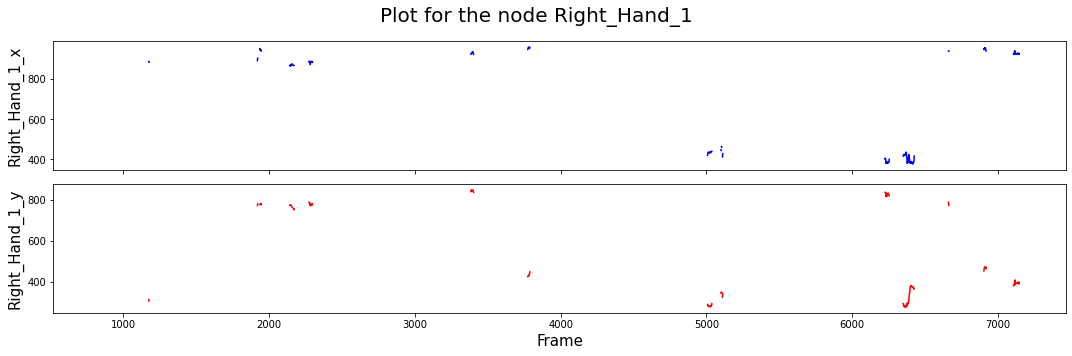

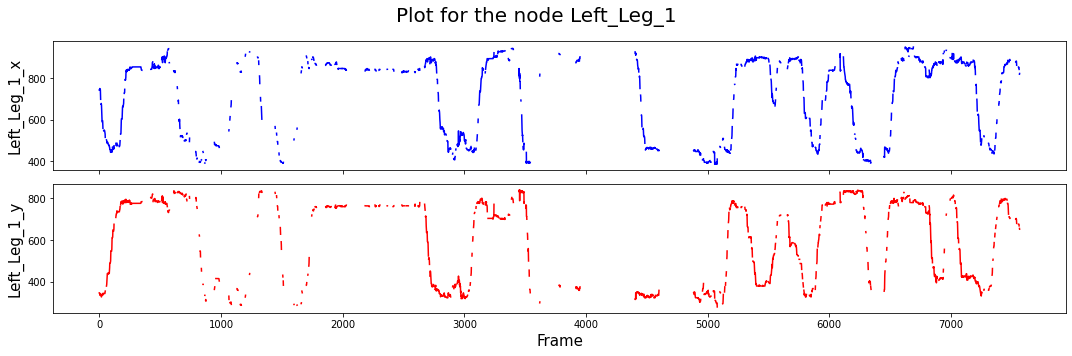

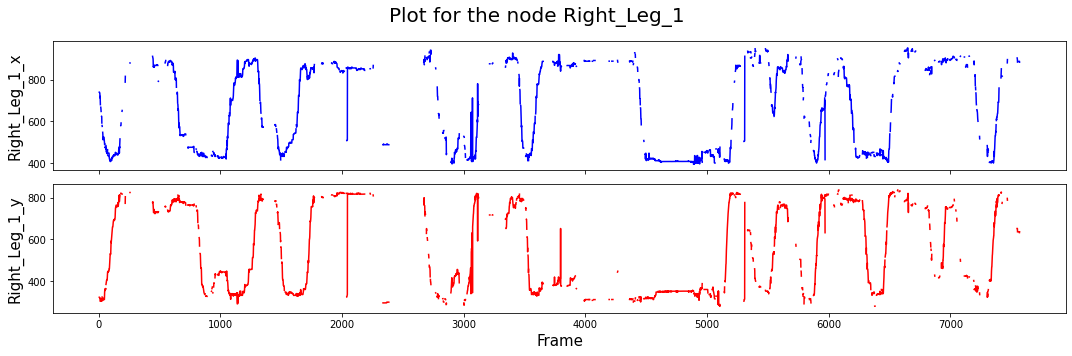

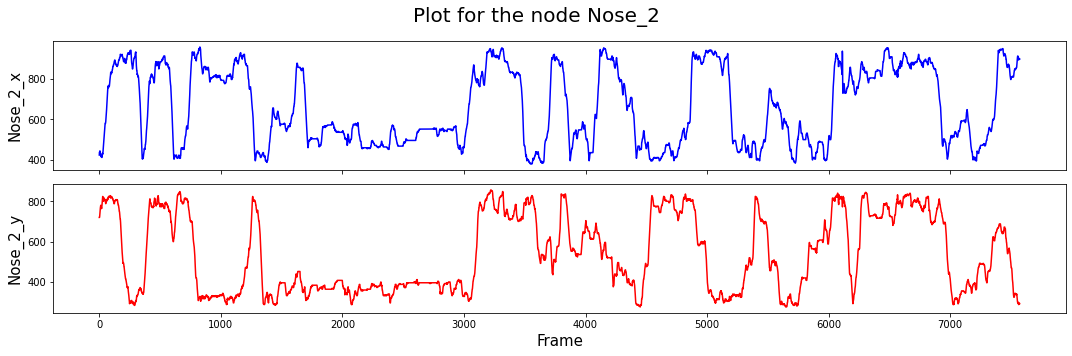

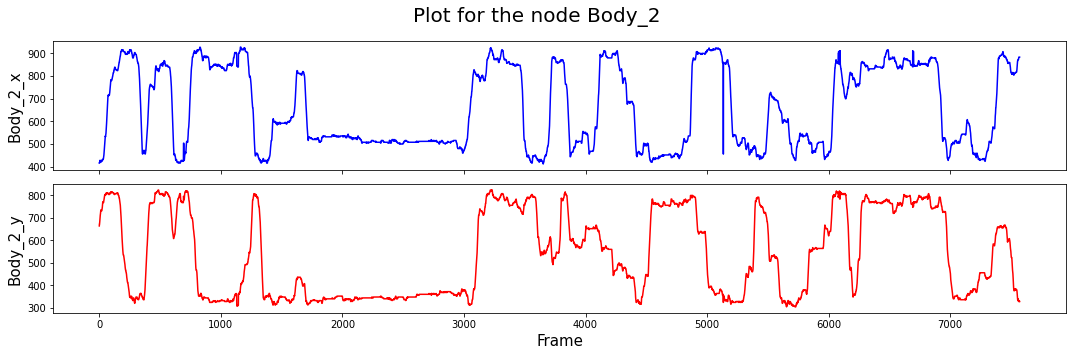

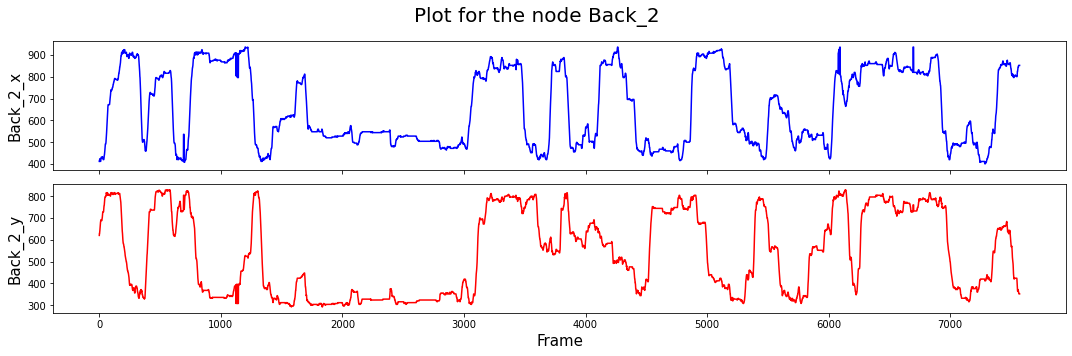

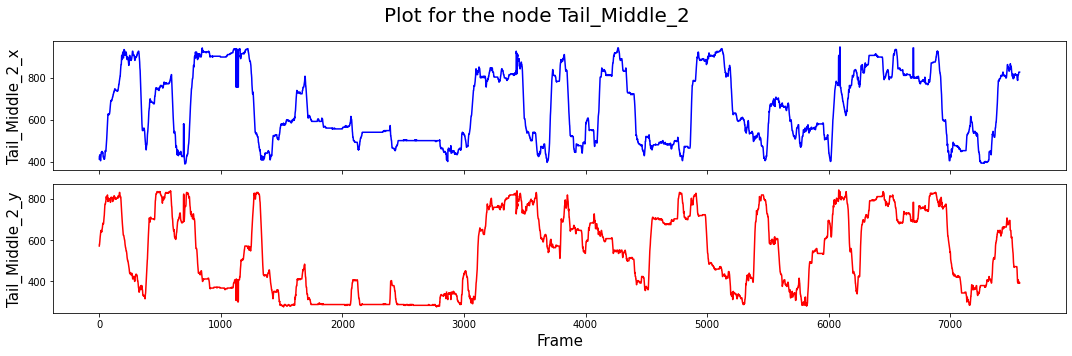

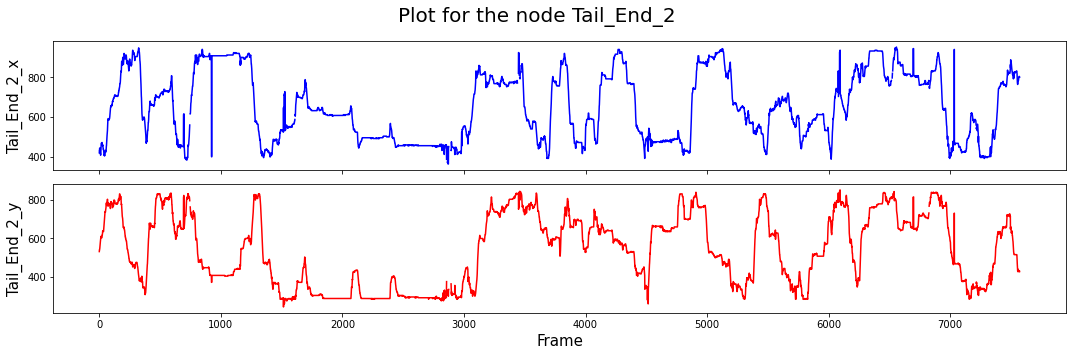

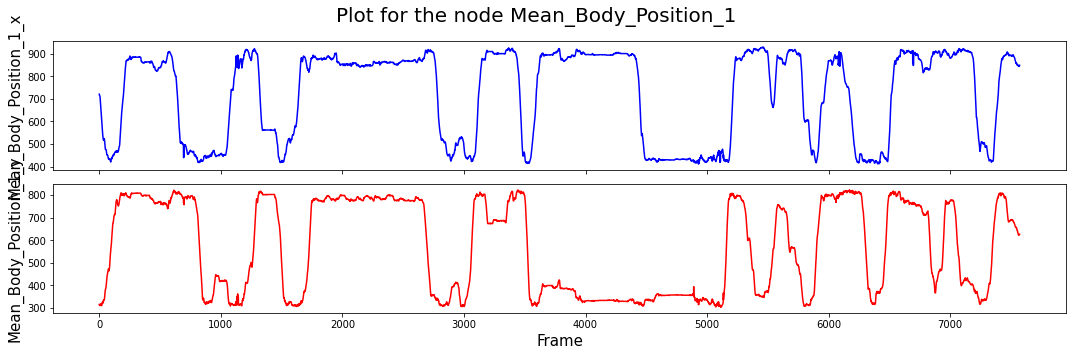

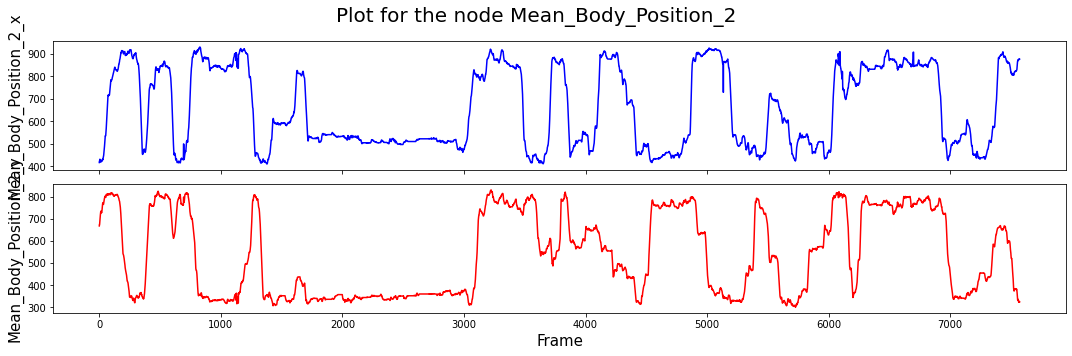

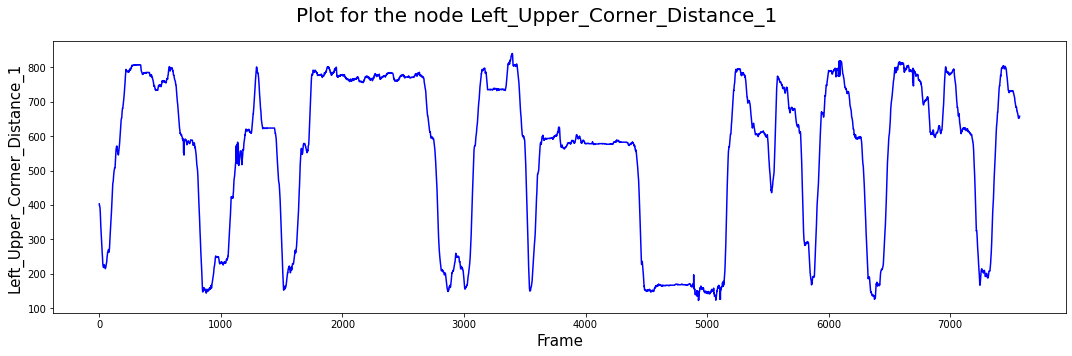

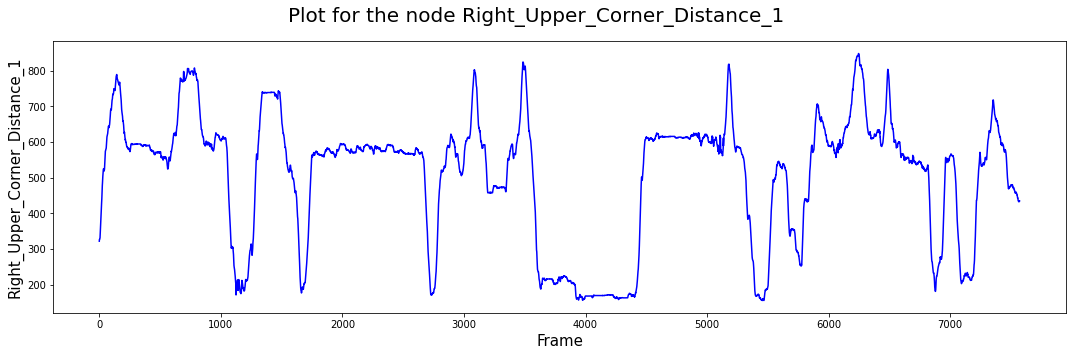

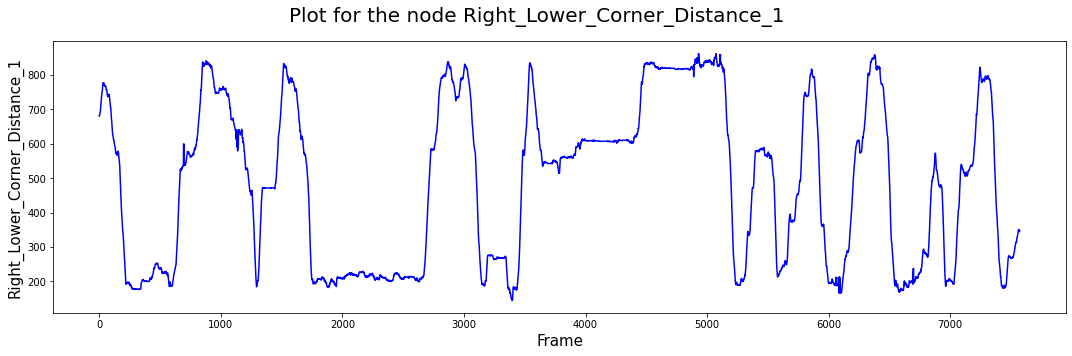

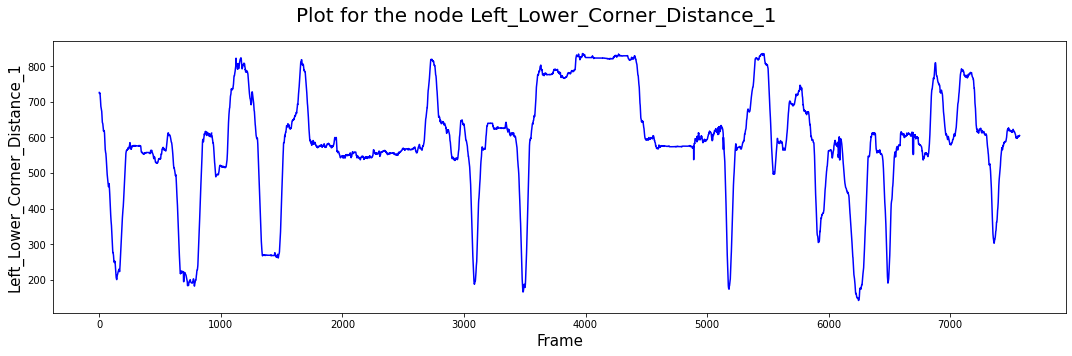

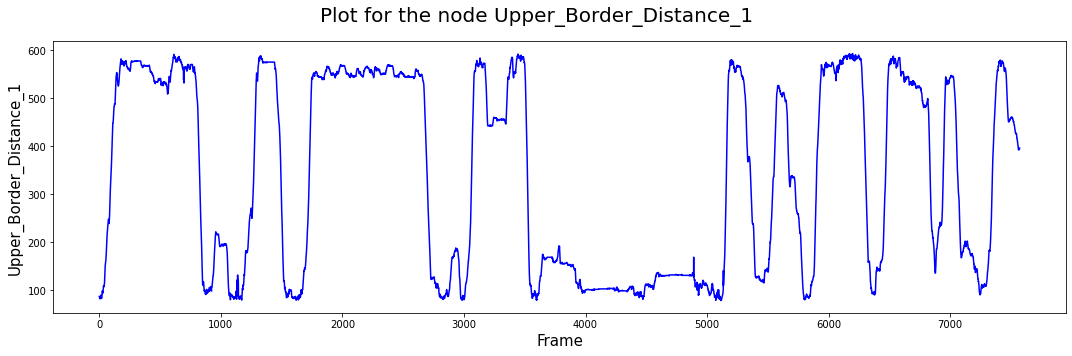

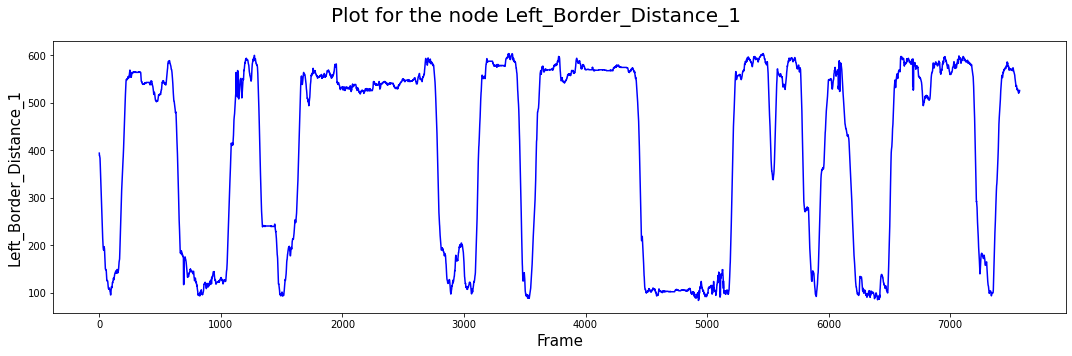

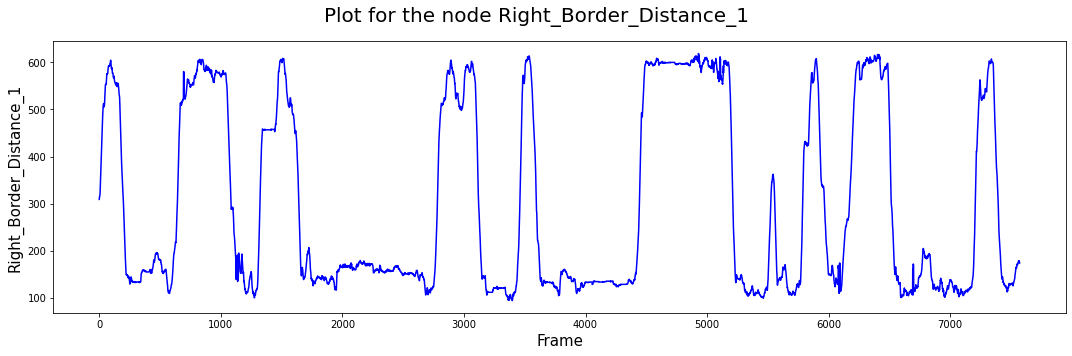

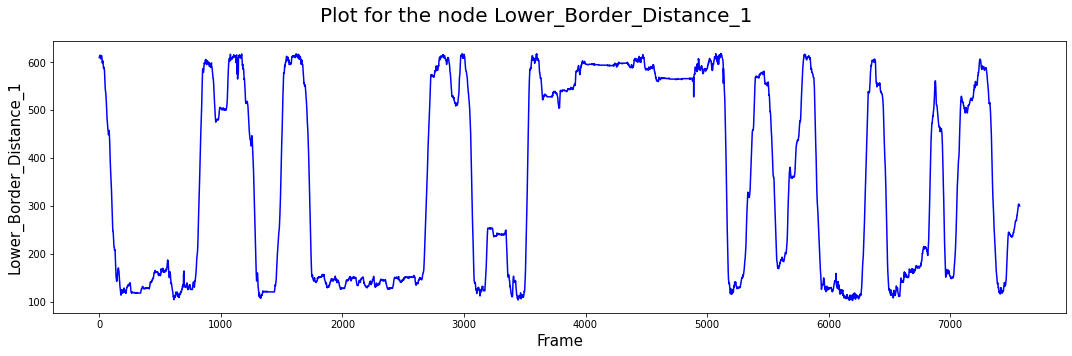

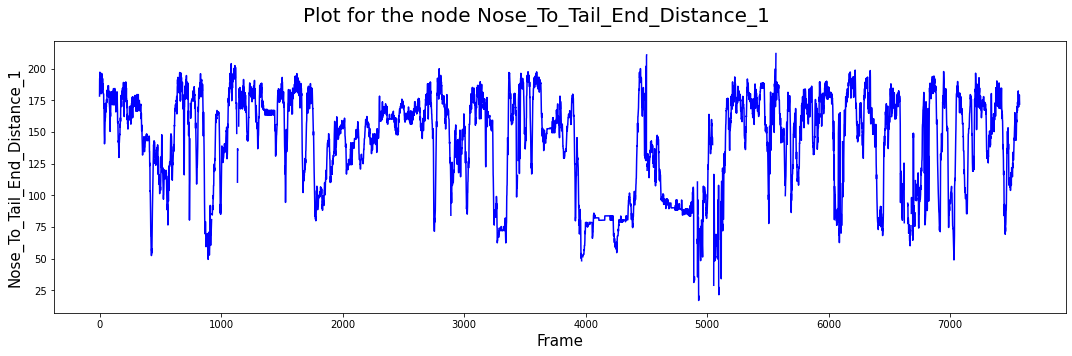

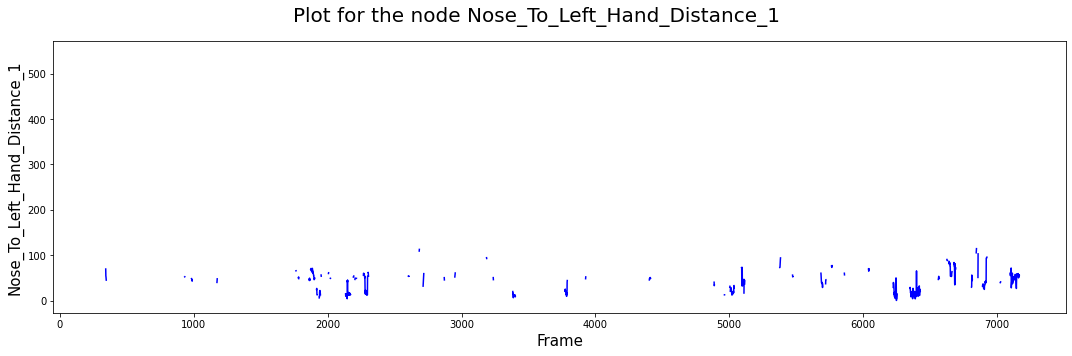

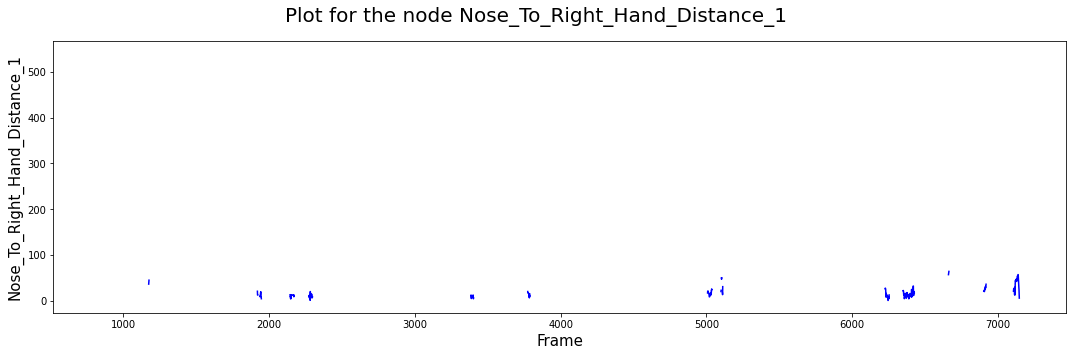

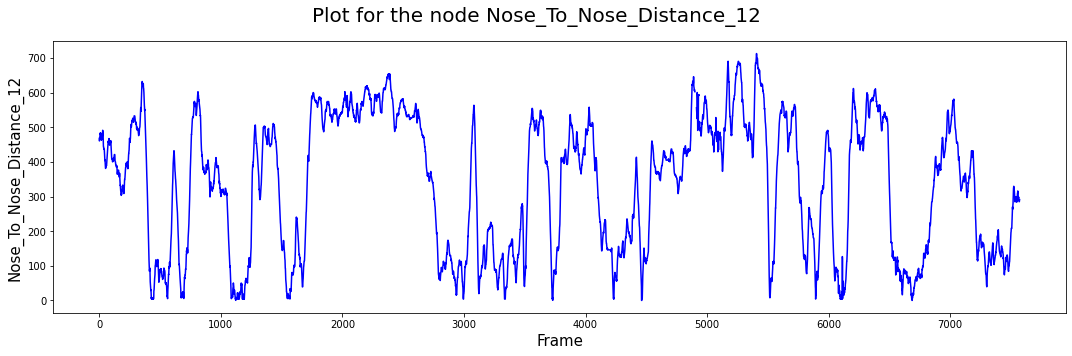

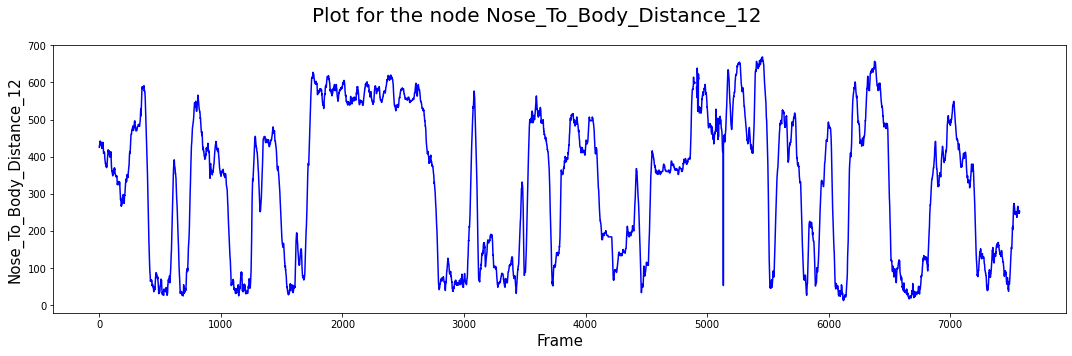

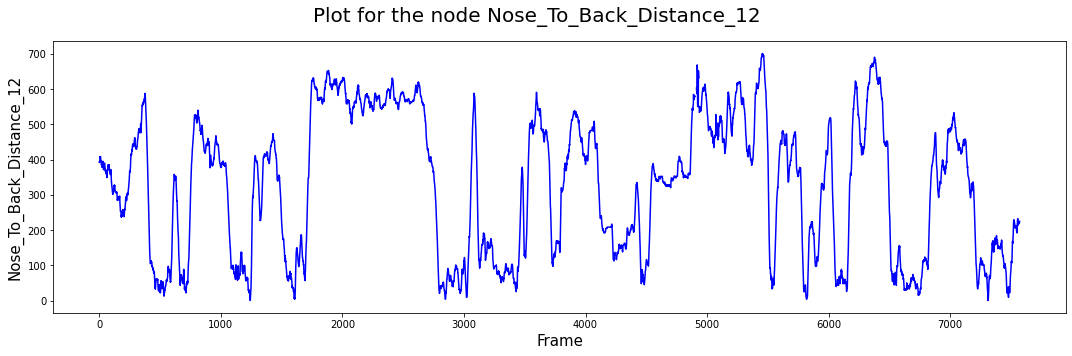

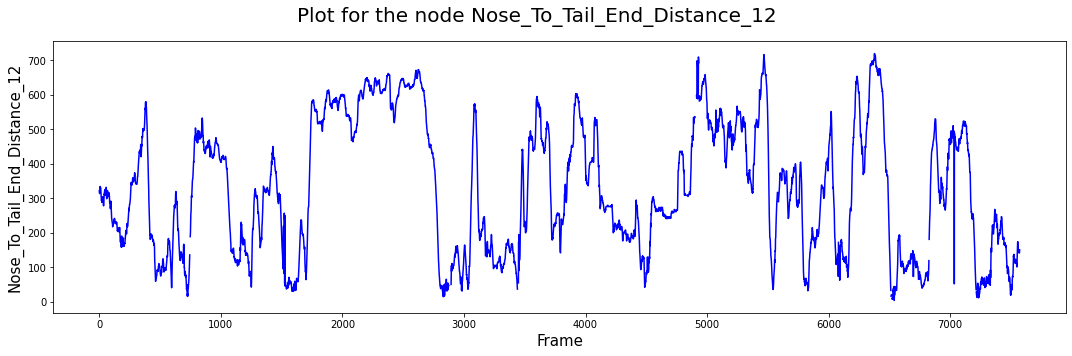

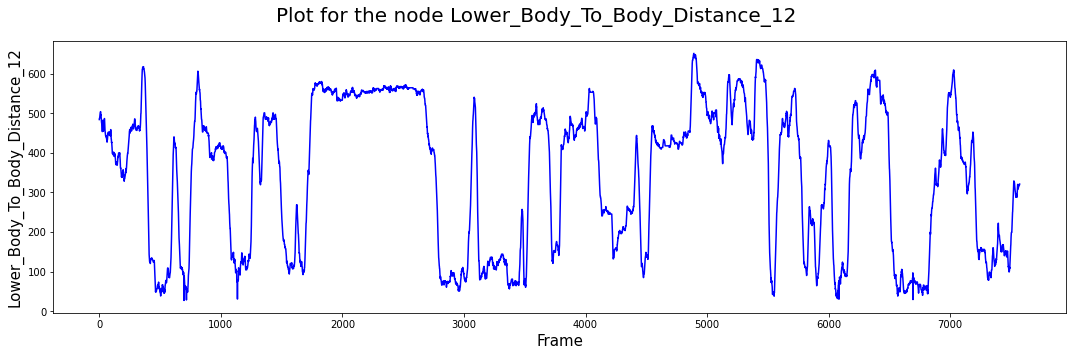

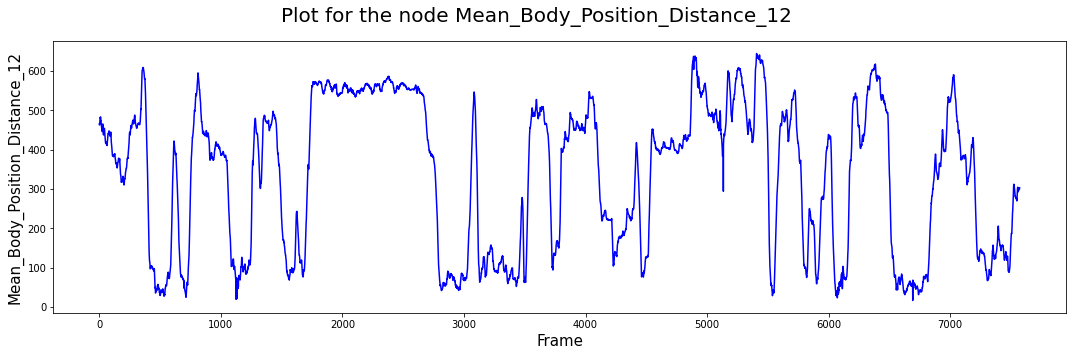

In [20]:
def plot_keypoints(df):
    for node_name in df.columns:
        if 'score' in node_name or node_name.endswith('_y'):
            continue
            
        if node_name.endswith('_x'):
            node_name = node_name[:-2]
            fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15, 5))

            ax[0].plot(df.index, df[f'{node_name}_x'], color='blue')
            ax[0].set_ylabel(f'{node_name}_x', fontsize=15)

            ax[1].plot(df.index, df[f'{node_name}_y'], color='red')
            ax[1].set_ylabel(f'{node_name}_y', fontsize=15)
        else:
            fig, ax = plt.subplots(figsize=(15, 5))

            ax.plot(df.index, df[f'{node_name}'], color='blue')
            ax.set_ylabel(f'{node_name}', fontsize=15)

        fig.suptitle(f'Plot for the node {node_name}', fontsize=20)
        plt.xlabel('Frame', fontsize=15)
        plt.tight_layout()
        plt.show();
    
plot_keypoints(df)

In [ ]:
def plot_histogram(df):
    for node_name in df.columns:
        if 'score' in node_name or node_name.endswith('_y'):
            continue
            
        if node_name.endswith('_x'):
            node_name = node_name[:-2]
            fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

            df[f'{node_name}_x'].hist(color='blue', ax=ax[0])
            ax[0].set_xlabel(f'{node_name}_x', fontsize=15)
            ax[0].set_ylim([0, 2000])
            ax[0].set_xlim([0, 1000])
            ax[0].set_ylabel('Frequency', fontsize=15)

            df[f'{node_name}_y'].hist(color='red', ax=ax[1])
            ax[1].set_xlabel(f'{node_name}_y', fontsize=15)
            ax[1].set_ylim([0, 2000])
            ax[1].set_xlim([0, 1000])
        else:
            fig, ax = plt.subplots(figsize=(10, 5))

            df[f'{node_name}'].hist(color='blue', ax=ax)
            ax.set_xlabel(f'{node_name}', fontsize=15)
            ax.set_ylim([0, 2000])
            ax.set_xlim([0, 1000])
            ax.set_ylabel('Frequency', fontsize=15)

        fig.suptitle(f'Frequency histogram for the node {node_name}', fontsize=20)
        plt.tight_layout()
        plt.show();
    
plot_histogram(df)

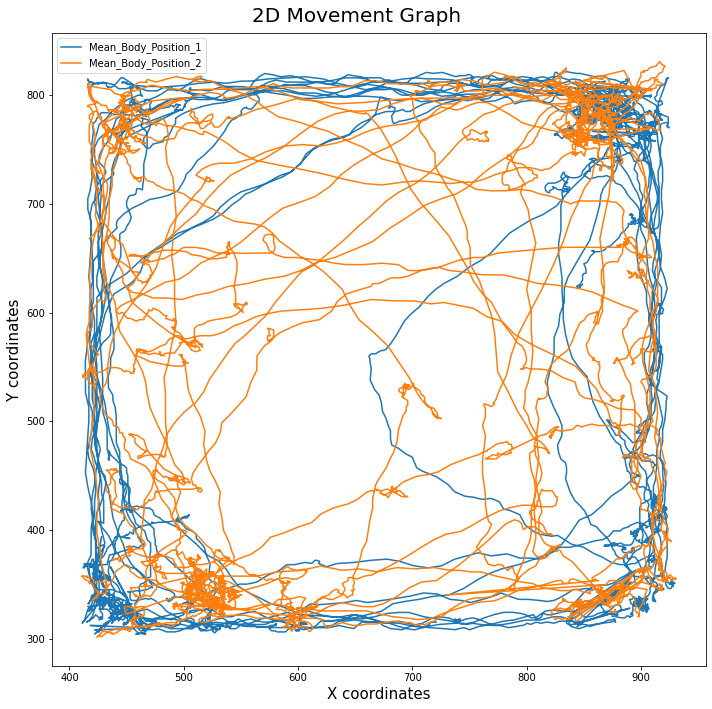

In [20]:
def plot_2d_movement_graph(df, cols):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    if isinstance(cols, list):
        idx = 0
        
        for col in cols:
            ax.plot(df[f'{col}_x'].values, df[f'{col}_y'], label=col)
            idx += 1
    else:
        ax.plot(df[f'{cols}_x'].values, df[f'{cols}_y'], color='red')
        
    ax.set_xlabel('X coordinates', fontsize=15)
    ax.set_ylabel('Y coordinates', fontsize=15)

    fig.suptitle(f'2D Movement Graph', fontsize=20)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show();
    
plot_2d_movement_graph(df, ['Mean_Body_Position_1', 'Mean_Body_Position_2'])

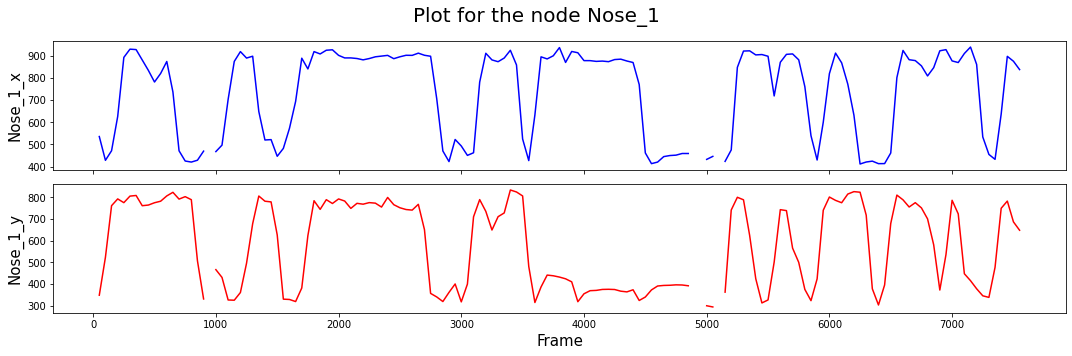

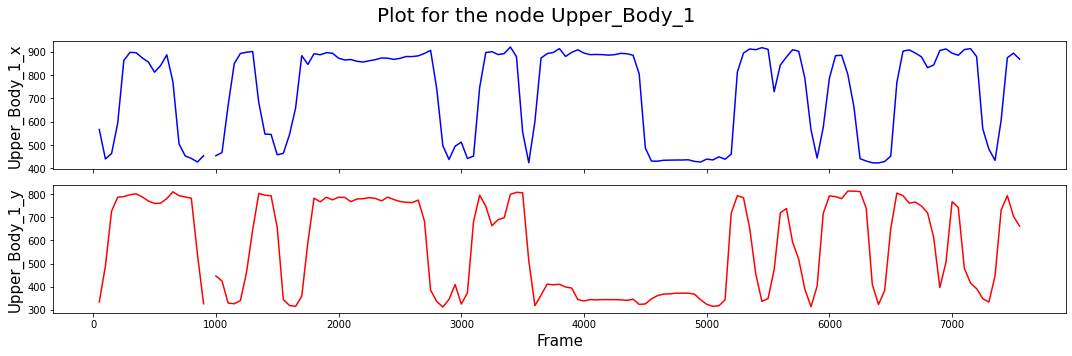

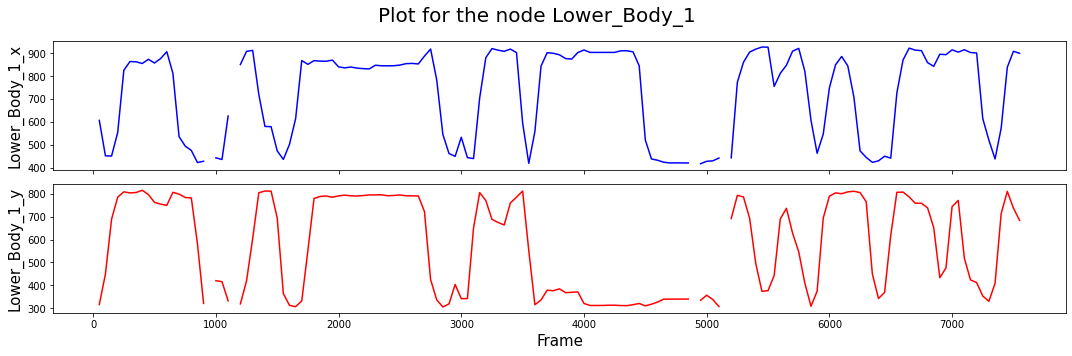

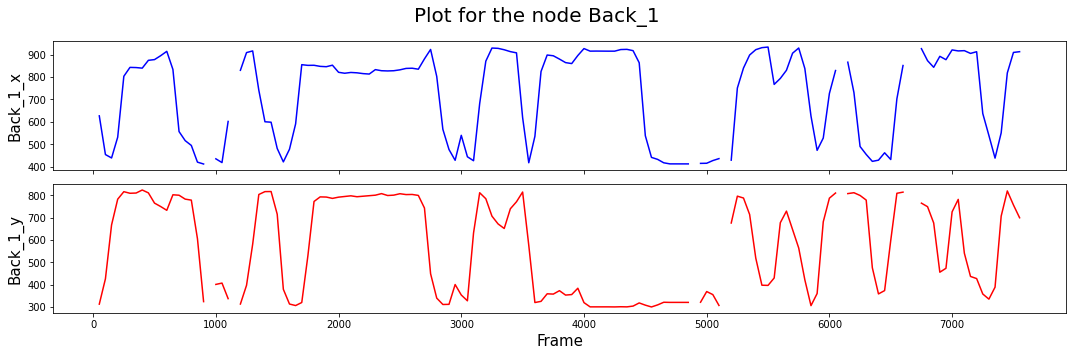

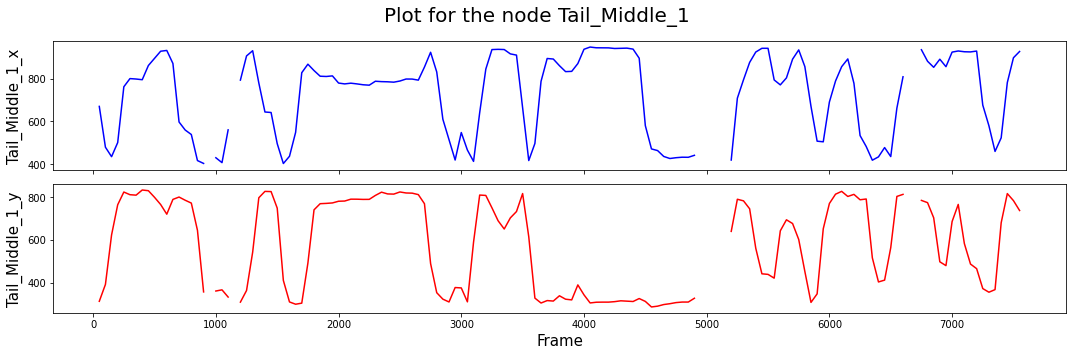

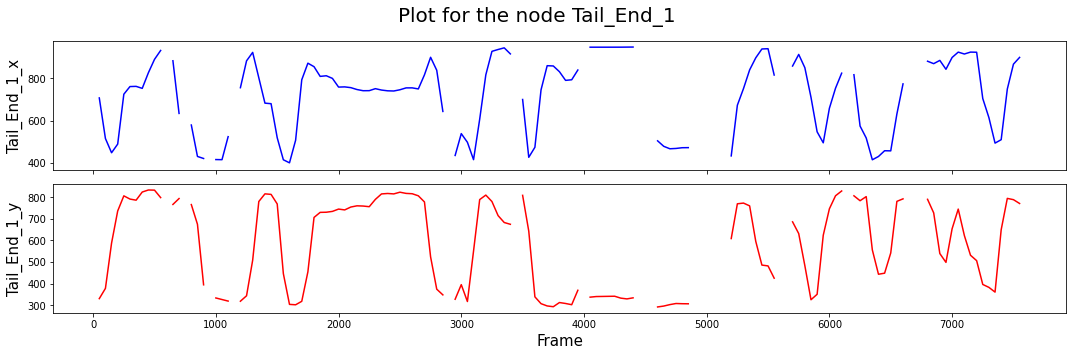

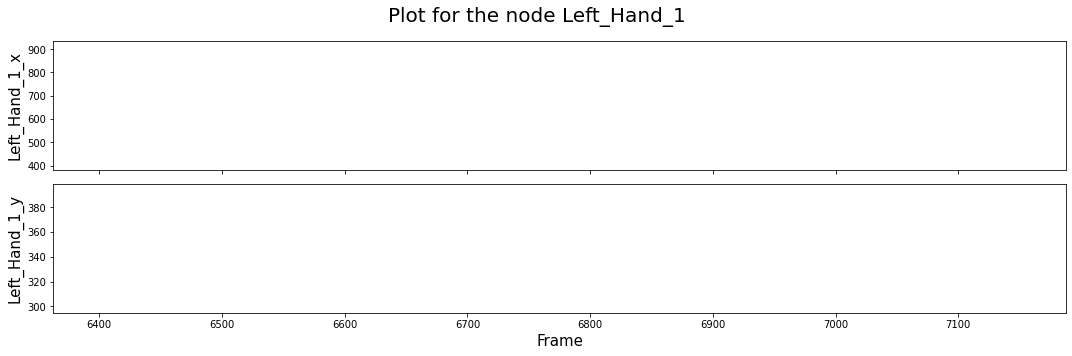

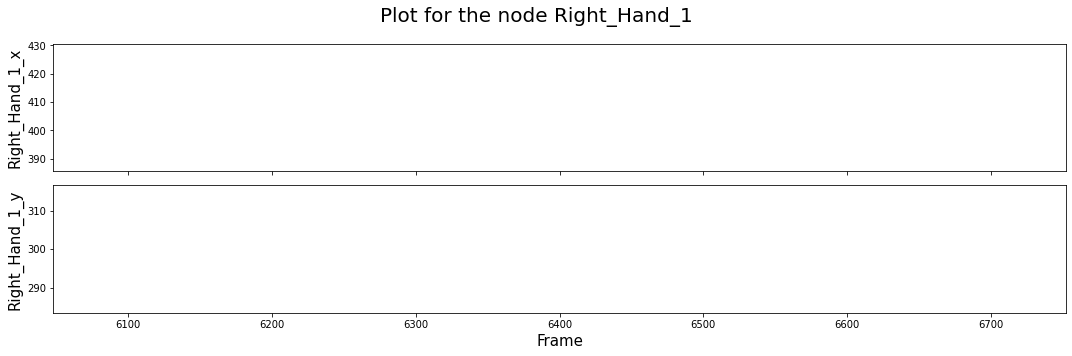

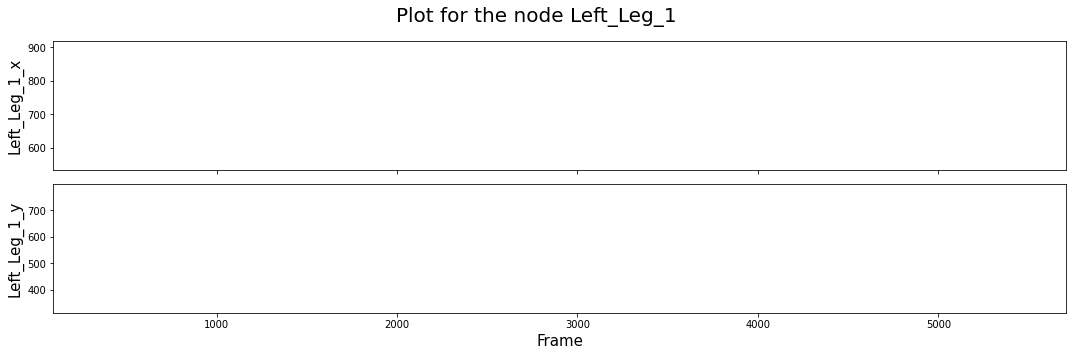

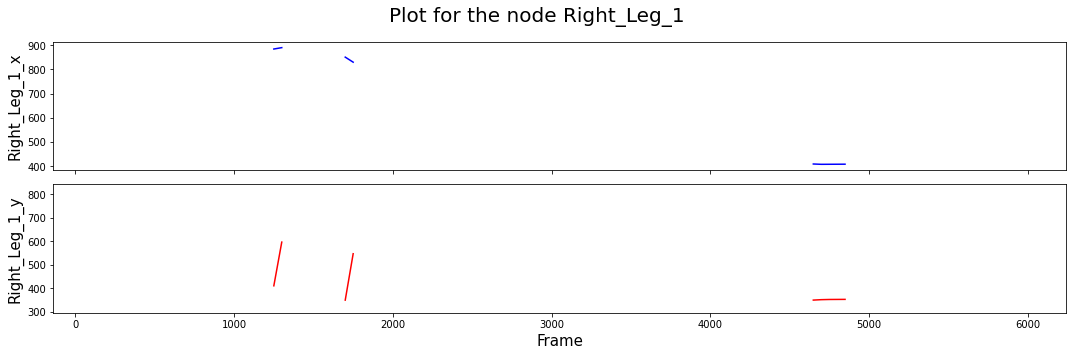

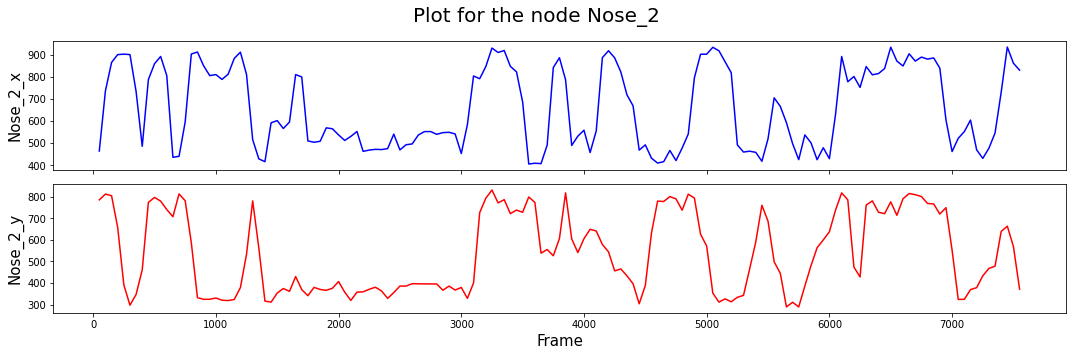

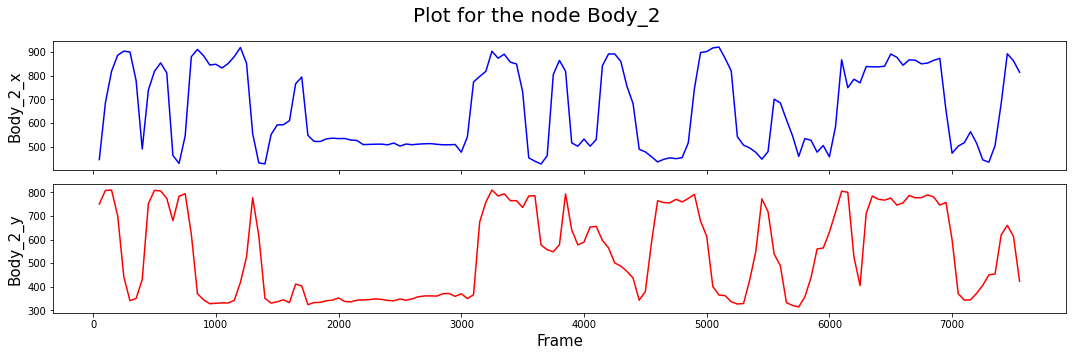

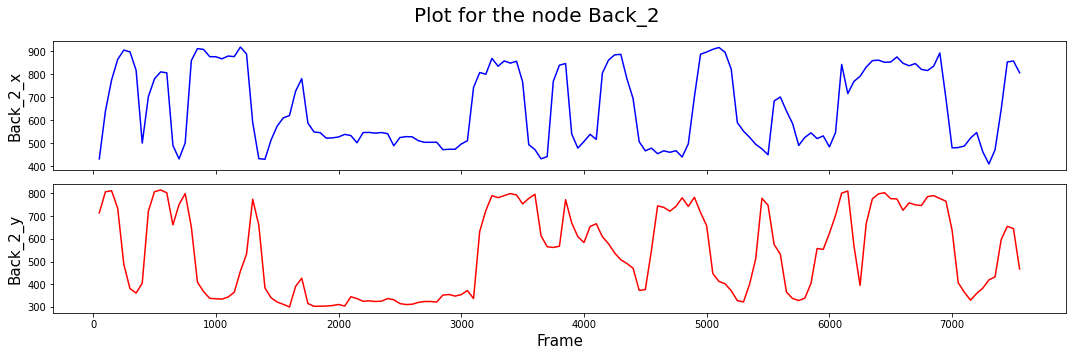

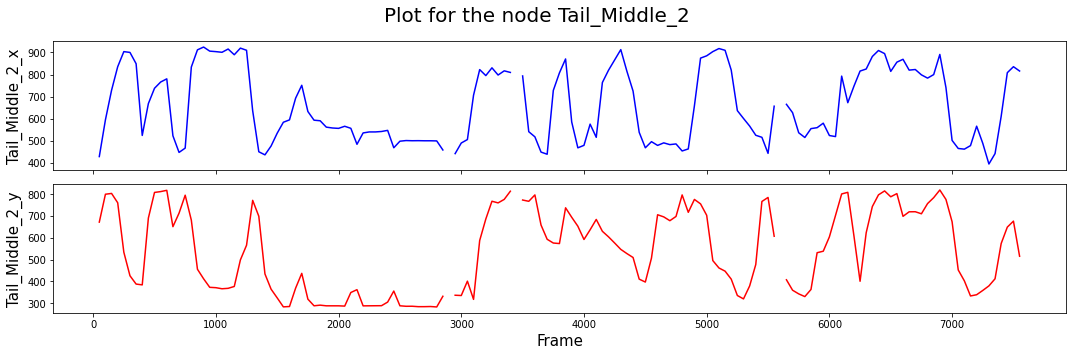

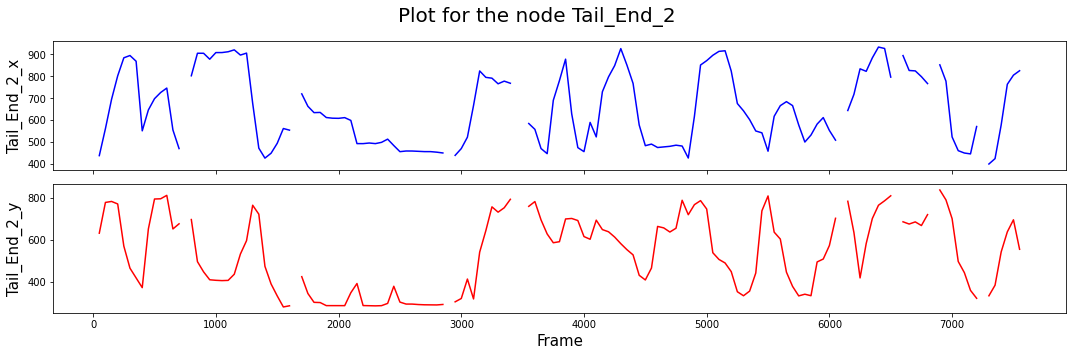

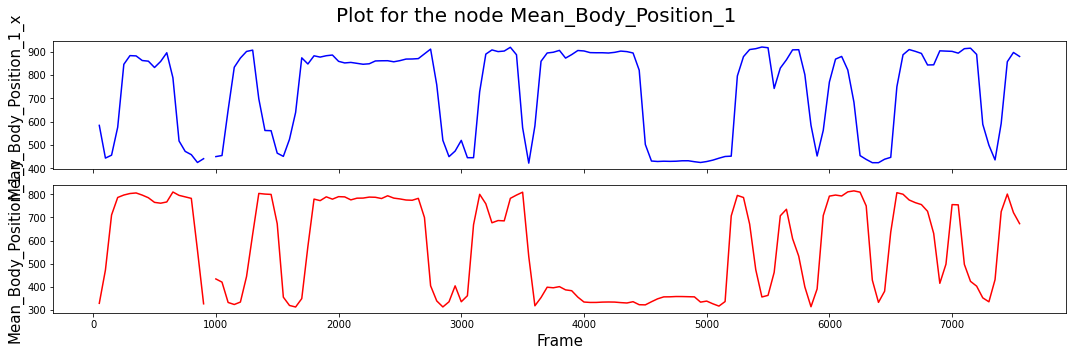

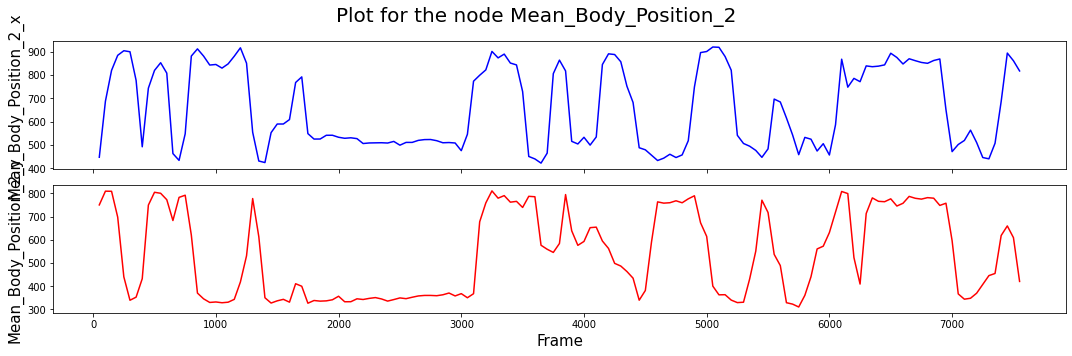

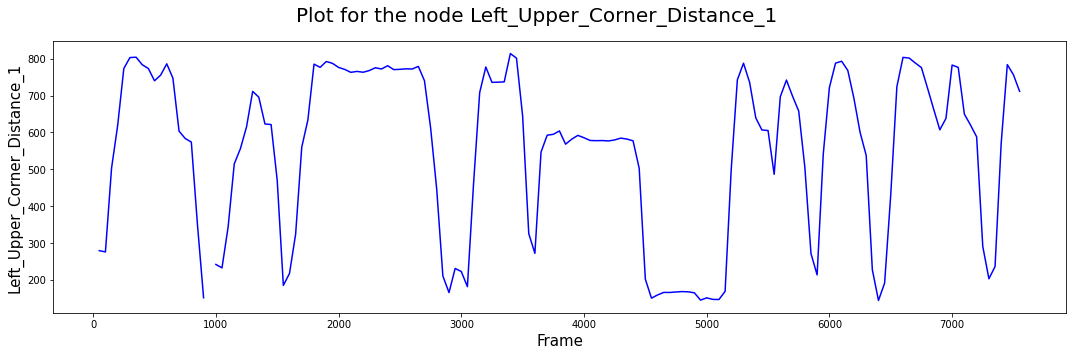

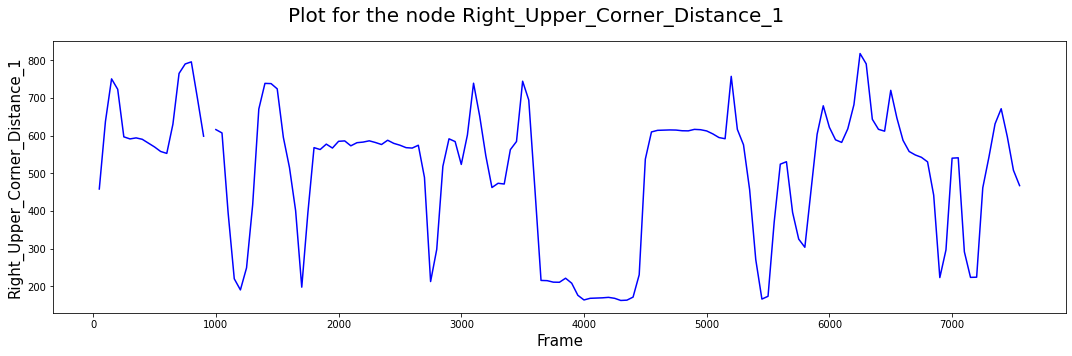

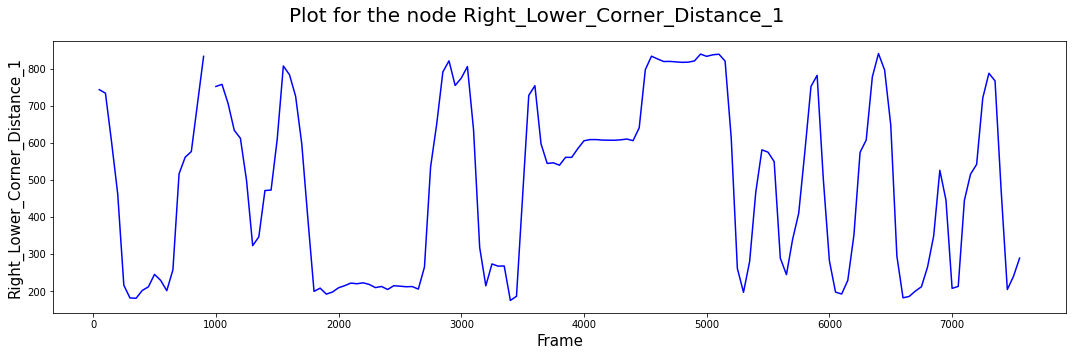

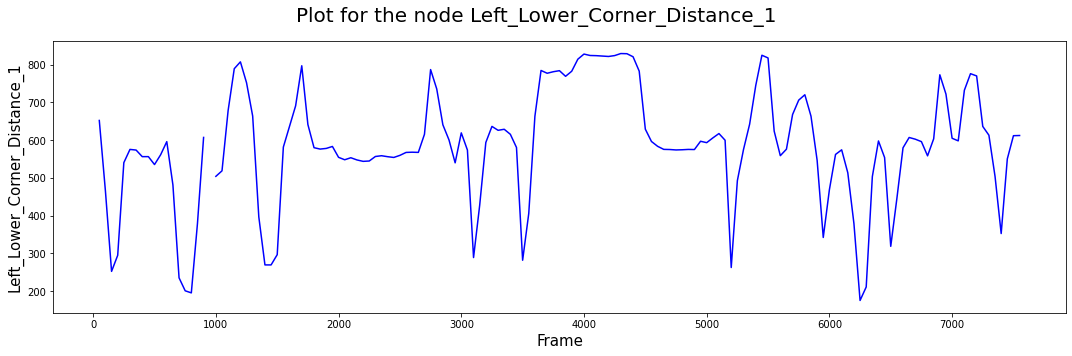

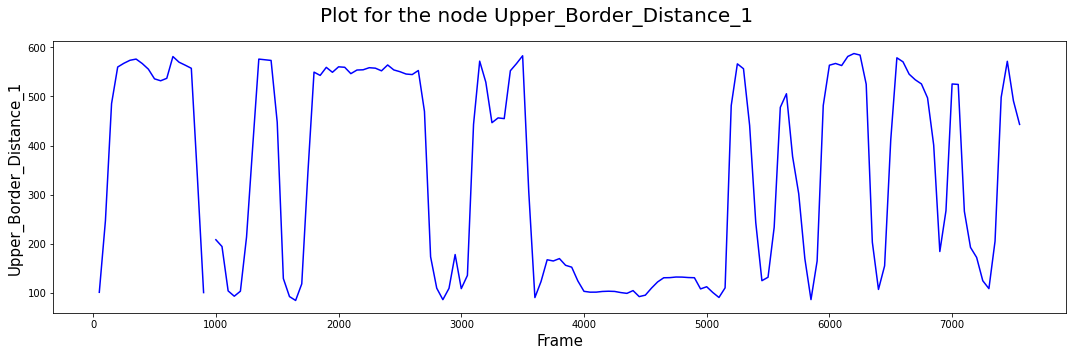

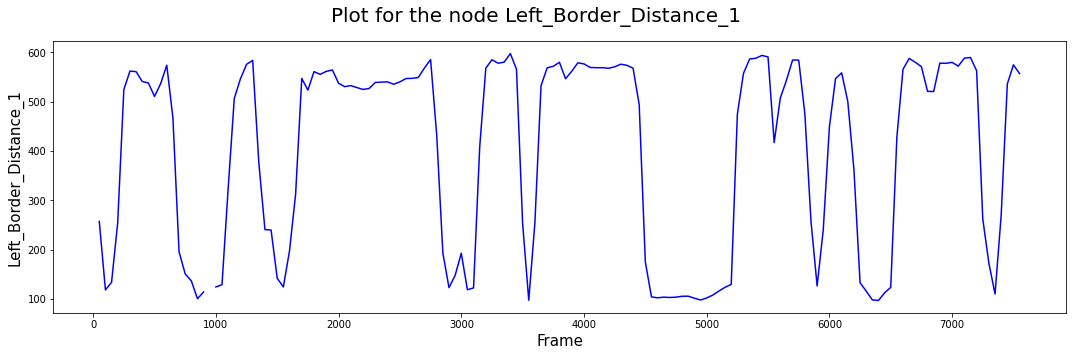

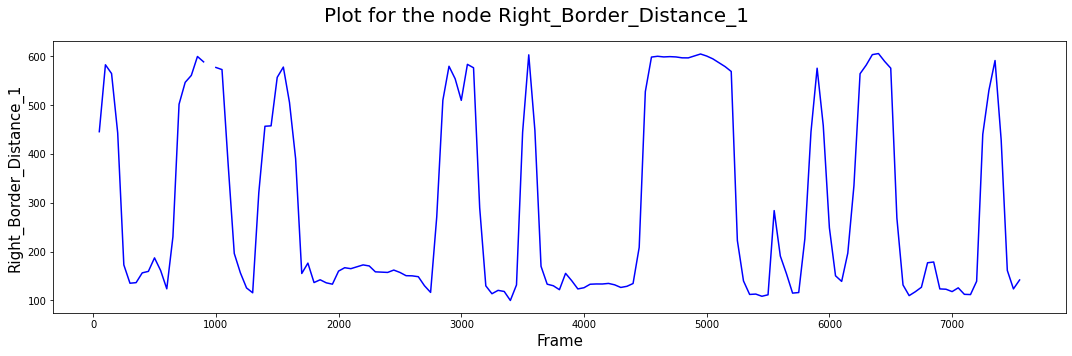

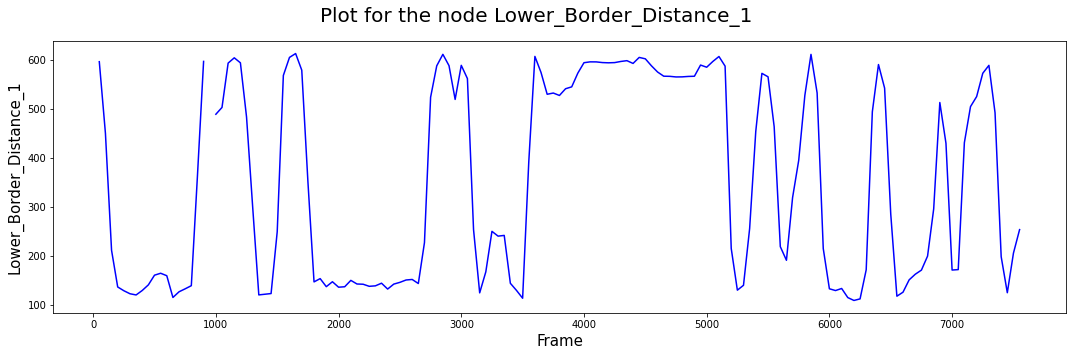

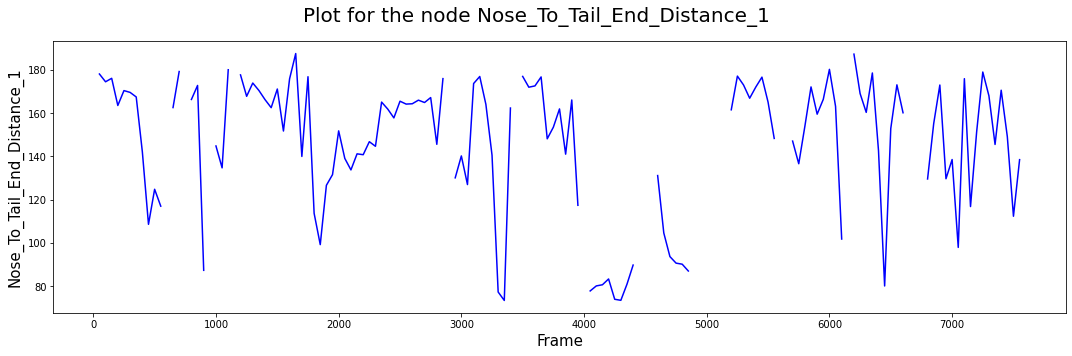

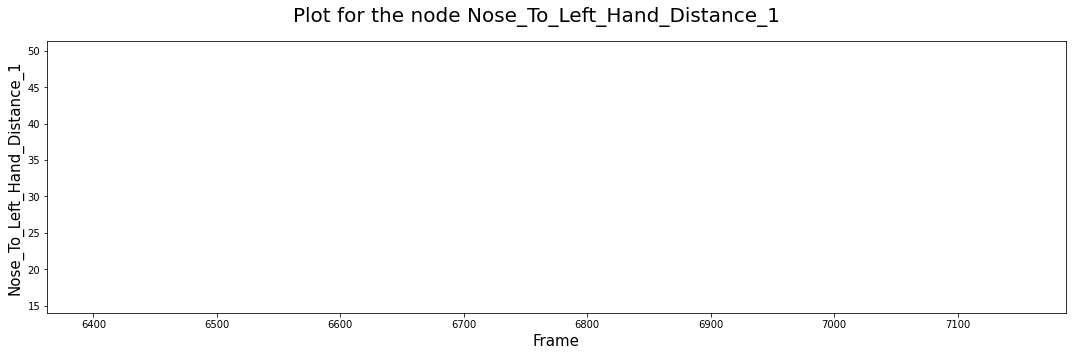

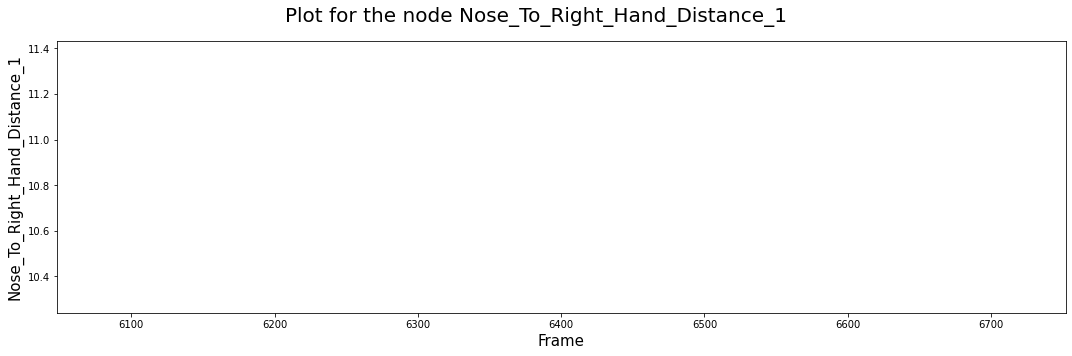

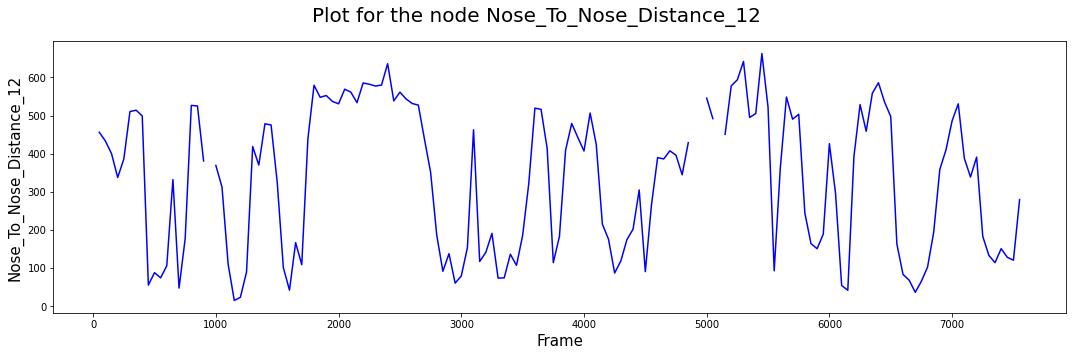

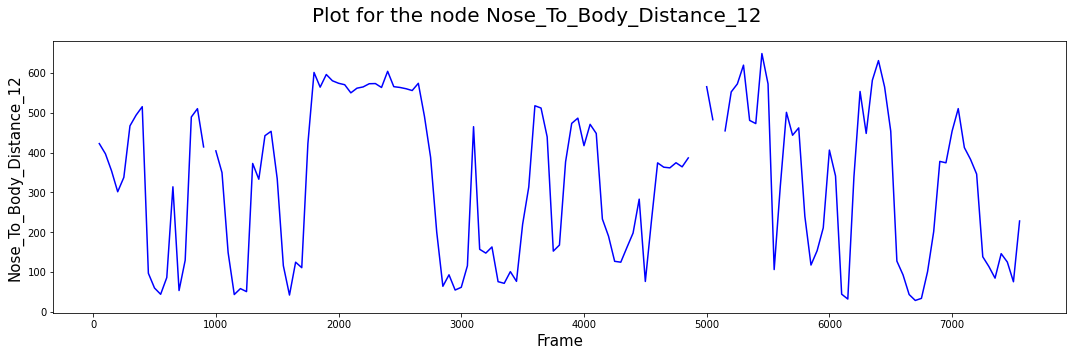

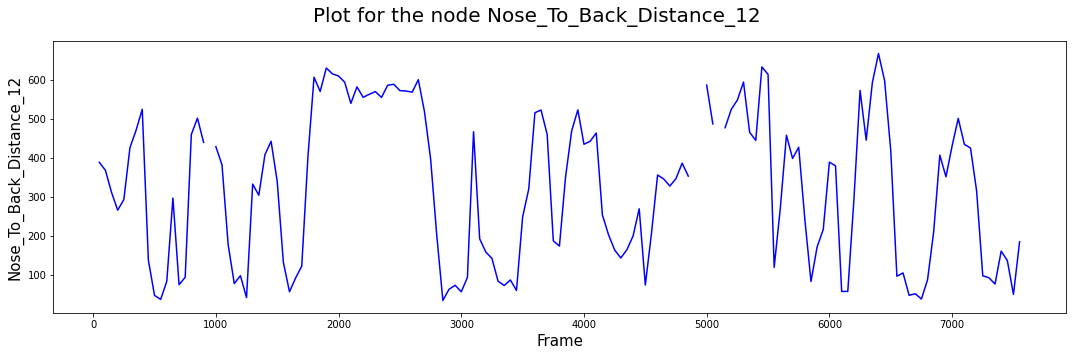

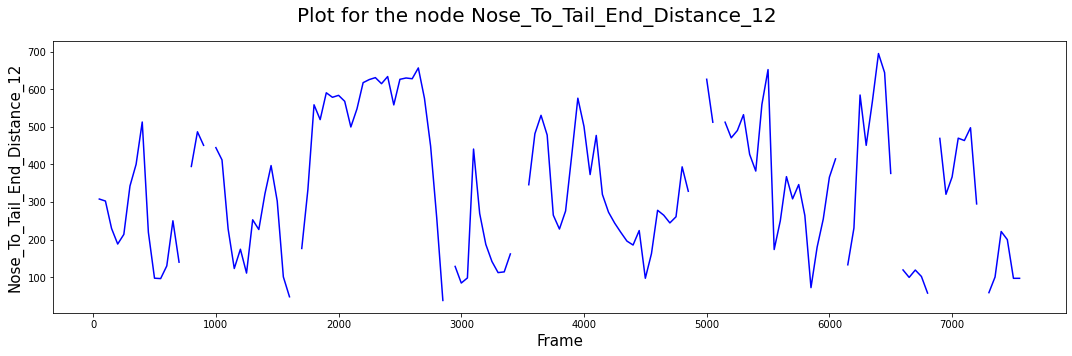

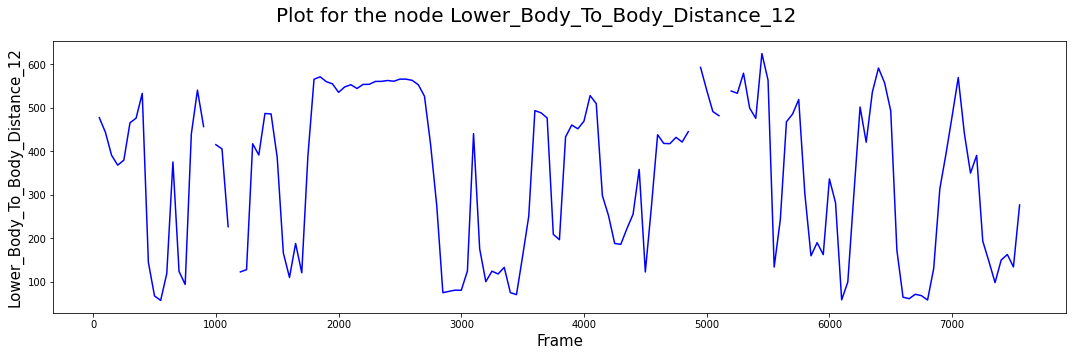

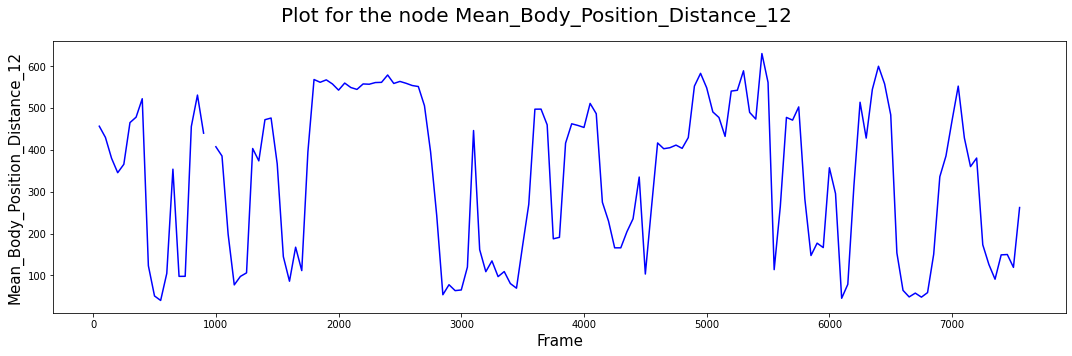

In [28]:
def plot_average_keypoints(df, window=1):
    temp_df = df.rolling(window).mean().iloc[::window, :]
    
    for node_name in temp_df.columns:
        if 'score' in node_name or node_name.endswith('_y'):
            continue
            
        if node_name.endswith('_x'):
            node_name = node_name[:-2]
            fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15, 5))

            ax[0].plot(temp_df.index, temp_df[f'{node_name}_x'], color='blue')
            ax[0].set_ylabel(f'{node_name}_x', fontsize=15)

            ax[1].plot(temp_df.index, temp_df[f'{node_name}_y'], color='red')
            ax[1].set_ylabel(f'{node_name}_y', fontsize=15)
        else:
            fig, ax = plt.subplots(figsize=(15, 5))

            ax.plot(temp_df.index, temp_df[f'{node_name}'], color='blue')
            ax.set_ylabel(f'{node_name}', fontsize=15)

        fig.suptitle(f'Plot for the node {node_name}', fontsize=20)
        plt.xlabel('Frame', fontsize=15)
        plt.tight_layout()
        plt.show();
    
plot_average_keypoints(df, window=50)